# Image Classification with Deep Learning- Project#4

* Student name: ***Deepali Sharma***
* Student pace: ***Flex***
* Scheduled project review date/time: ***April, 2023***
* Instructor name: ***Abhineet Kulkarni***

# Business Problem
**Piedmont group, is looking for hiring a Data Scientist who can build a realistic model to efficiently screen the chest X-rays in pediatric patients that have pneumonia. 
They have certain remote locations where Radiology Department has only one Radiologist and so they often have troubles when Radiologist is out for certain reasons**
* Piedmont wants to avoid any lag in patient care and safety, minimize the diagnosis time and faster treatment timelines, and decrease the workload for Radiologist.
* My job is to build a Neural Network that detects the presence of pneumonia in X-ray images. I need to predict the status of the lungs (Normal vs pneumonia) as accurately as possible
while maximizing recall, i.e. identify majority of the **True Positive cases correctly** so that we catch as many kids with pneumonia as possible.

# Analysis Approach
* This is an image classification problem that we will tackle using different neural networks and pre-trained modules. This analysis used followimg models:
    * Artificial Neural Networks, also known as Neural Nets)(ANN or NN).
    * Convolutional Neural Networks (CNNs)
    * Pre-trained Modules: We will use Xception and RESNET101
* We will implement various techniques to improve model performance and avoid overfitting such as Dropout, L2 Regularization and varying learning rate for ANNs and CNNs. We also use data augmentation to train our models on more data with various modifications
* We will use confusion matrix as the performance metric. In particular we want to minimize  the false negatives for pneumonia cases as we dont want patients with pneumonia to be mis-diagonsed.

# Executive Summary
* The **CNN model with deeper layers** and trained on augmented data performed the best. The recall score for the pneumonia cases was 99% and for normal cases was 76%
* The second best model was the pre-trained model **Xception** with additional layers added to it. The recall score for pneumonia cases was 96% and for normal cases was 81%

In [1]:
#import system related libs
import os, sys, shutil,time
print(sys.executable)

# import basic libs
import pandas as pd
import numpy as np
import random
import math
import datetime

#import plotting libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

#import sklearn libs
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn import preprocessing
#from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import plot_confusion_matrix # plot_confusion_matrix is a visual tool added in the latest version of scikit-learn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score,confusion_matrix, classification_report

#import NN/Keras related libs

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

#import warnings
import warnings
warnings.filterwarnings('ignore')


/usr/local/anaconda3/bin/python


Using TensorFlow backend.


In [2]:
original_start = datetime.datetime.now()
start = datetime.datetime.now()

# Preprocessing Data
* Count the number of files available
* Look at the images before doing any data processing


In [3]:
train_dir_pneum  = 'train/PNEUMONIA'
train_dir_normal = 'train/NORMAL' 
test_dir_pneum   = 'test/PNEUMONIA'
test_dir_normal  = 'test/NORMAL' 
total_pneum  = len(os.listdir(train_dir_pneum)) + len(os.listdir(test_dir_pneum))
total_normal = len(os.listdir(train_dir_normal)) + len(os.listdir(test_dir_normal))
total_images = total_pneum+total_normal

print('Train Dataset:')
print('There are', len(os.listdir(train_dir_pneum)), 
      'Pneumonia images(' ,round(len(os.listdir(train_dir_pneum))/total_images,2),")" )
print('There are', len(os.listdir(train_dir_normal)), 
      'Normal images(' ,round(len(os.listdir(train_dir_normal))/total_images,2),")")
print('\n\nTest Dataset:')
print('There are', len(os.listdir(test_dir_pneum)),
      'Pneumonia images(' ,round(len(os.listdir(test_dir_pneum))/total_images,2),")")
print('There are', len(os.listdir(test_dir_normal)),
      'Normal images(' ,round(len(os.listdir(test_dir_normal))/total_images,2),")")


Train Dataset:
There are 3883 Pneumonia images( 0.66 )
There are 1349 Normal images( 0.23 )


Test Dataset:
There are 390 Pneumonia images( 0.07 )
There are 234 Normal images( 0.04 )


* There is roughly **89%** data in train set and **10%** in test dataset
* Lets just randomly pick one image and look at its dimensions, pixels and color information

Image number displayed will be: 1875
Image Shape: (1145, 1658, 3)
Max pixel: 255.0
Min pixel: 0.0


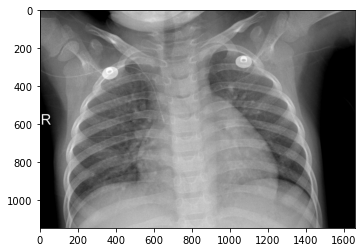

In [5]:
#generate random number between 0 to 3800
img_num = np.random.randint(3800)
print(f"Image number displayed will be: {img_num}")
img_path = os.listdir(train_dir_pneum)[img_num]


img = image.load_img(os.path.join(train_dir_pneum, img_path))#, target_size=(255, 255))
img_tensor = image.img_to_array(img)

print(f"Image Shape: {img_tensor.shape}")  # width and height
print(f"Max pixel: {img_tensor.max()}")
print(f"Min pixel: {img_tensor.min()}")
#print(f"Image: {img_tensor}")

# Display the image
plt.imshow(img, cmap='gray'); # plt.imshow(img_array.astype('uint8'))

* Lets look at a bunch of images from pneumonia and normal classes. We will pick 5 images from each class randomly

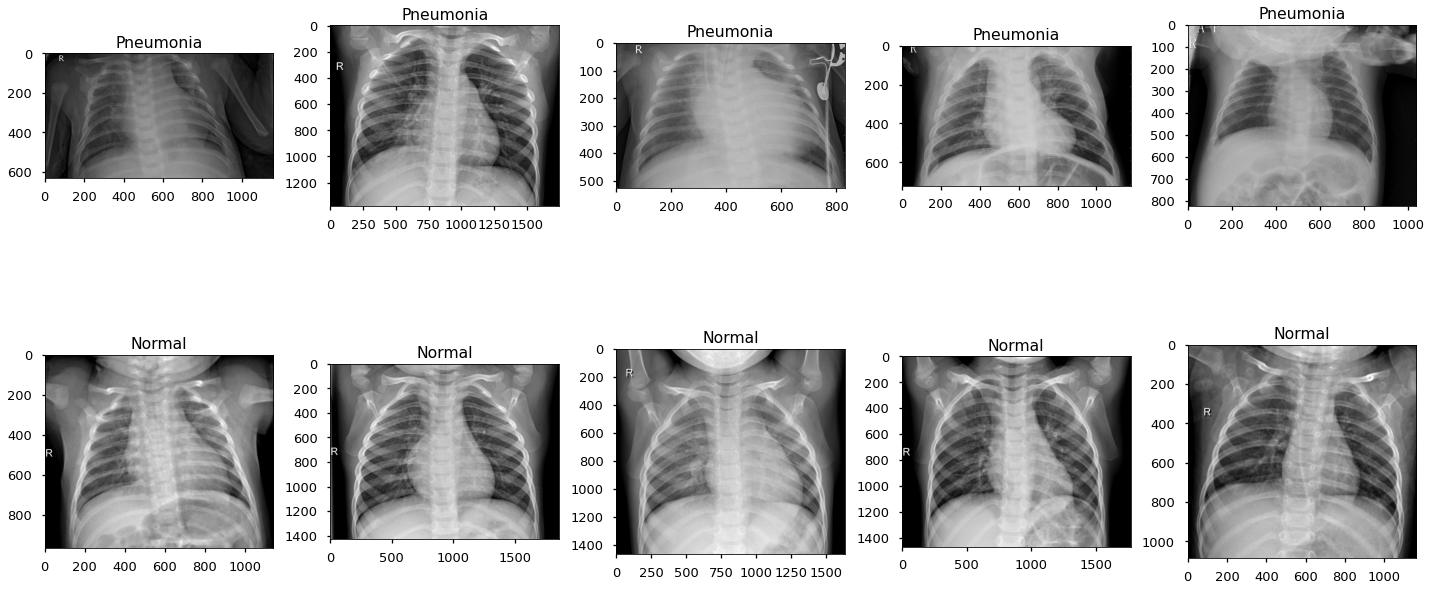

In [428]:
max_pixel_size =[]
min_pixel_size =[]
img_height     =[]
img_width      =[]
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(nrows =2, ncols = 5, figsize=(20,10))  

    plt_img_pneum = np.random.randint(3883, size=5)
    plt_img_normal = np.random.randint(1349, size=5)
    for i in range(5):
        # Combine the image directory with the specific jpeg to be able to locate it
        # Read the image into an array.
        img_path      = os.listdir(train_dir_pneum)[plt_img_pneum[i]]
        img_pneum     = image.load_img(os.path.join(train_dir_pneum, img_path))
        
        img_path      = os.listdir(train_dir_normal)[plt_img_normal[i]]
        img_normal    = image.load_img(os.path.join(train_dir_normal, img_path))
    
        img_tensor_pneum = image.img_to_array(img_pneum)
        img_tensor_normal= image.img_to_array(img_normal)
        max_pixel_size.append(img_tensor_pneum.max())
        max_pixel_size.append(img_tensor_normal.max())
        min_pixel_size.append(img_tensor_pneum.min())
        min_pixel_size.append(img_tensor_normal.min())
        img_width.append(img_tensor_pneum.shape[1])
        img_width.append(img_tensor_normal.shape[1])
        img_height.append(img_tensor_pneum.shape[0])
        img_height.append(img_tensor_normal.shape[0])
        # Display the image
        ax[0,i].imshow(img_pneum, cmap = 'gray')
        ax[1,i].imshow(img_normal, cmap = 'gray')
        
        # ax[0,i].set_axis_off()
        # ax[1,i].set_axis_off()
            
        ax[0,i].set_title("Pneumonia")
        ax[1,i].set_title("Normal")

    plt.tight_layout()
    plt.savefig('./images/RawImages.png', dpi=300, bbox_inches='tight')

In [7]:
print(f'maximum pixel size array: {max_pixel_size}')
print(f'minimum pixel size array: {min_pixel_size}')
print(f'Image dimensions (width): {img_width}')
print(f'Image dimensions (height): {img_height}')

maximum pixel size array: [255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255.0]
minimum pixel size array: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Image dimensions (width): [1152, 2458, 952, 2101, 1000, 1454, 1416, 2088, 1568, 1836]
Image dimensions (height): [832, 1870, 528, 1606, 624, 978, 912, 2074, 1192, 1719]


* Looking at these arraus for resolution, pixelization we conclude the following:
    * The images have *different dimesions (resolution)*
    * The pixelization for all of them ranges between 0 to 255

### Transform the Image to a Tensor and Visualize Again
* We need to preprocess images into tensors wao as to use them for modeling using deep learning.
* Lets see now if rescaling affects the image quality since for modeling we will need to rescale the images. So we need to make sure that scaling doesnt result in any drastic changes.

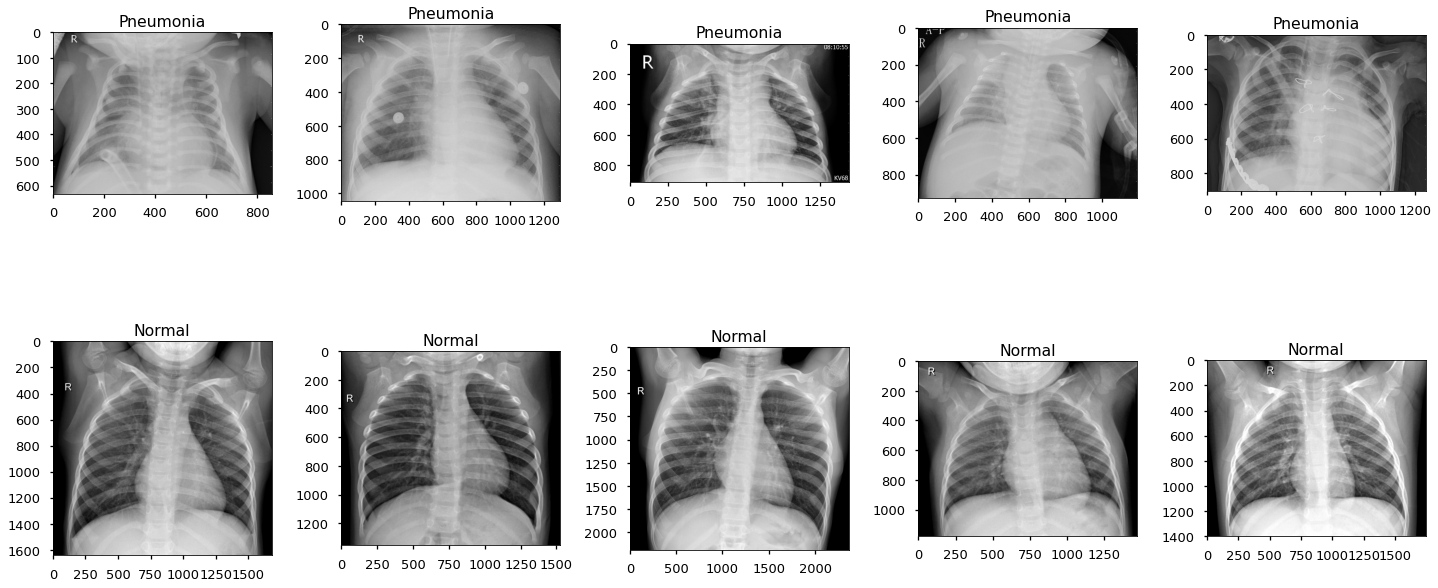

In [427]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(nrows =2, ncols = 5, figsize=(20,10))  
    for i in range(5):
        # Combine the image directory with the specific jpeg to be able to locate it
        # Read the image into an array.
        img_path      = os.listdir(train_dir_pneum)[plt_img_pneum[i]]
        img_pneum     = image.load_img(os.path.join(train_dir_pneum, img_path))
        
        img_path      = os.listdir(train_dir_normal)[plt_img_normal[i]]
        img_normal    = image.load_img(os.path.join(train_dir_normal, img_path))
    
        img_tensor_pneum = image.img_to_array(img_pneum)
        img_tensor_normal= image.img_to_array(img_normal)
        
        img_tensor_pneum /= 255.
        img_tensor_normal /= 255.
        # Display the image
        ax[0,i].imshow(img_pneum, cmap = 'gray')
        ax[1,i].imshow(img_normal, cmap = 'gray')
        
        # ax[0,i].set_axis_off()
        # ax[1,i].set_axis_off()
            
        ax[0,i].set_title("Pneumonia")
        ax[1,i].set_title("Normal")

    plt.tight_layout()
    plt.savefig('./images/ScaledImages', dpi=300, bbox_inches='tight')

* We dont see any issues with the images after scaling them down.

## Splitting the train set into train and validation sets

* We use the splitfolders package (https://pypi.org/project/split-folders/) to achieve this
* The original train data provided by Kaggle "train" with "Pneumonia" and "Normal" subfolders was re-arranged into a new output folder "output" with "train" and "val" subfolders as well. The train foldeer contains 90% and validation folder containing 10% of the data (from original train dataset from Kaggle). 
* This would leave us with 80% of total data for model training purposes, 10% for validation and 10% for test purposes (This folder is same as the original Test data provided by Kaggle).

In [113]:
#from PIL import Image
#import cv2
#!pip install split-folders

In [12]:
import splitfolders

In [13]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
#splitfolders.ratio("./train", output="output",
#    seed=1337, ratio=(.9, .1), group_prefix=None, move=False) # default values


### Lets check that we got the right fraction of data sets for train, test and val

Train Pneumomia: 3494
Train Normal: 1214
-------------------
Test Pneumomia: 390
Test Normal: 234
--------------------
Val Pneumomia: 389
Val Normal: 135
--------------------
Train Images Percentage: 0.804
Test Images Percentage: 0.107
Val Images Percentage: 0.089


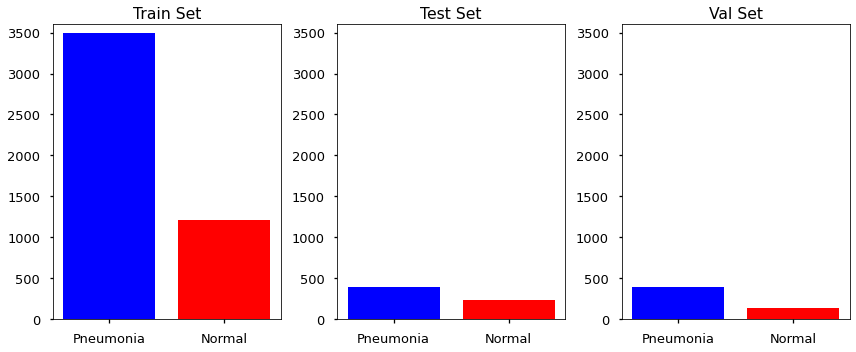

In [426]:
num_pneum_train = (len(os.listdir("output/train/PNEUMONIA")) ) 
num_normal_train = (len(os.listdir("output/train/NORMAL")) )
                       
num_pneum_test = (len(os.listdir("test/PNEUMONIA")) )
num_normal_test = (len(os.listdir("test/NORMAL")) )
      
num_pneum_val = (len(os.listdir("output/val/PNEUMONIA")) )
num_normal_val = (len(os.listdir("output/val/NORMAL")))
                             
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.bar(x = ["Pneumonia","Normal"], height=[num_pneum_train, num_normal_train], color=["blue", "red"])
    ax1.set_title('Train Set')
    ax2.bar(x = ["Pneumonia","Normal"], height=[num_pneum_test, num_normal_test], color=["blue", "red"])
    ax2.set_title('Test Set')
    ax3.bar(x = ["Pneumonia","Normal"], height=[num_pneum_val, num_normal_val], color=["blue", "red"]) 
    ax3.set_title('Val Set')
    
    ax1.set_ylim([0, 3600])
    ax2.set_ylim([0, 3600])
    ax3.set_ylim([0, 3600])
    plt.tight_layout()
    
print(f"Train Pneumomia: {num_pneum_train}")
print(f"Train Normal: {num_normal_train}")
print("-------------------")
print(f"Test Pneumomia: {num_pneum_test}")
print(f"Test Normal: {num_normal_test}")
print("--------------------")
print(f"Val Pneumomia: {num_pneum_val}")
print(f"Val Normal: {num_normal_val}")
print("--------------------")
          
TrainTotal = num_pneum_train + num_normal_train
TestTotal = num_pneum_test + num_normal_test
ValTotal = num_pneum_val + num_normal_val
Total = TrainTotal + TestTotal + ValTotal
print(f"Train Images Percentage: {np.round((TrainTotal / Total),3) }")
print(f"Test Images Percentage: {np.round((TestTotal / Total),3) }")
print(f"Val Images Percentage: {np.round((ValTotal / Total),3) }") 

In [15]:
print(f"Train Images Total#: {TrainTotal}")
print(f"Test Images Total#: {TestTotal}")
print(f"Val Images Total#: {ValTotal}")

Train Images Total#: 4708
Test Images Total#: 624
Val Images Total#: 524


## Image preprocessing (Keras ImageDataGenerator)
This is an essential step in deep learning and computer vision tasks, such as object detection, image classification, and segmentation. We will do the following steps to prepare the images for modeling:
* Resizing and Rescaling: Images are often resized to a fixed input size, and their pixel values are rescaled to a common range. Rescaling the pixel values helps to normalize the input data and reduce the effects of lighting and contrast variations. Since all our images are of different sizes we will rescale (standardize) them using a target width and height. The resolutions for training CNNs usually range between 64 × 64 and 256 × 256. The analysis done with resolution 256x256 yielded lower perfomance for models, so I decided to use 128x128
* Normalization: Normalizing the pixel values of an image can help to reduce the effects of lighting and contrast variations. We will normalize the images by 255(the maximum pixel size in these images).
* Label the target data into 1's (pneumonia) and 0's (normal) # class_mode='binary'

In [16]:
train_folder = "output/train"
test_folder  = "test/"
val_folder   = "output/val"

In [17]:
IMG_SIZE=128#256

In [18]:
# get all the data in the directory test , and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(IMG_SIZE, IMG_SIZE), 
        batch_size = TestTotal,
        class_mode='binary') 

# get all the data in the directory split/validation , and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size = ValTotal,
        class_mode='binary')

# get all the data in the directory split/train , and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=TrainTotal,
        class_mode='binary')

Found 624 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 4708 images belonging to 2 classes.


In [19]:
print(train_generator.class_indices)
print(train_generator.image_shape, test_generator.image_shape, val_generator.image_shape)

{'NORMAL': 0, 'PNEUMONIA': 1}
(128, 128, 3) (128, 128, 3) (128, 128, 3)


In [20]:
# create the data sets
## This will be used for CNN models as they need 3x3 input
# next() returns the next item in the iterator = The first batch of the images, in our case all images.
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [21]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4708
Number of testing samples: 624
Number of validation samples: 524
train_images shape: (4708, 128, 128, 3)
train_labels shape: (4708,)
test_images shape: (624, 128, 128, 3)
test_labels shape: (624,)
val_images shape: (524, 128, 128, 3)
val_labels shape: (524,)


# Modeling

# 1.  ANN -Models:
An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron receives signals then processes them and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called edges. Neurons and edges typically have a weight that adjusts as learning proceeds. The weight increases or decreases the strength of the signal at a connection. Neurons may have a threshold such that a signal is sent only if the aggregate signal crosses that threshold.Typically, neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times(https://en.wikipedia.org/wiki/Artificial_neural_network).
## 1a. Baseline ANN Model
* We will use a densely connected network(ANN) as a baseline model with only one hidden layer with 10 neutrons, and an output layer with one output. 
* We will use "Adam(Adaptive Adaptive Moment Estimation)" optimizer which essentially combines RMSProp and momentum by storing both the individual learning rate of RMSProp and the weighted average of momentum. The adaptive optimizers are generally faster compared to standard SGD. However, it has been argued as well that 'sgd' performs better in terms of generalization performance (https://medium.com/geekculture/a-2021-guide-to-improving-cnns-optimizers-adam-vs-sgd-495848ac6008).
* The input vector has 49512 rows(128 x 128 x 3).
* For this we need to reshape our tensors into vectors.

In [22]:
# our train shape is 4708, 128, 128, 3. Reshaping will change it to 4708,128x128
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4708, 49152)
(624, 49152)
(524, 49152)


In [23]:
train_labels.shape

(4708,)

In [24]:
# transform the labels from arrays to a 1D vector
train_y = np.reshape(train_labels, (train_images.shape[0],1))
test_y = np.reshape(test_labels, (test_images.shape[0],1))
val_y = np.reshape(val_labels, (val_images.shape[0],1))

In [25]:
print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

(4708, 1)
(624, 1)
(524, 1)


In [26]:
# Size of the image vector that needs to be input to the ANN models:
n_features = train_img.shape[1]

In [30]:
#We will use "adam" optimizer. A test run with 'sgd' resulted in lower model performance
# Initialize model
model = models.Sequential()

# First hidden layer
model.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))
# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
#The batch_size 44 is used as it is exact divisor of 4708(train data size)
ann_baseline_model = model.fit(train_img, train_y, epochs = 100, batch_size = 44, verbose =0, 
                    validation_data = (val_img, val_y))

In [31]:
results_train = model.evaluate(train_img, train_y)

148/148 [==============================] - 0s 1ms/step - loss: 0.0293 - accuracy: 0.9928


In [32]:
results_test = model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 1ms/step - loss: 1.4271 - accuracy: 0.8141


In [33]:
results_train

[0.029281755909323692, 0.9927782416343689]

In [34]:
results_test

[1.4270974397659302, 0.8141025900840759]

In [35]:
ann_baseline_model.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Evaluating model performance
* We will define a function that takes in the model, train and test datsets, and evalutaion metrics; accuracy and validation accuracy.
* The function will return the confusion matrix and also the model performance for test and train datsets.
* We are using confusion matrix since we want to maximize the correct prediction for true pneumonia cases: i.e. recall score

In [36]:
# Model evaluation function
def plot_model_performance(Model, Xtrain, Xtest, Acc, Val_acc):
    
    with plt.style.context('seaborn-talk'):
        
        # Diplay train and validation loss and accuracy:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
        ax1.plot(Model.history['loss'])
        ax1.plot(Model.history['val_loss'])
        ax1.set_title("Loss")
        ax1.legend(labels = ['Train Loss', 'Val Loss'])
        ax1.set_ylim(0,1)
        ax2.plot(Model.history[Acc])
        ax2.plot(Model.history[Val_acc])
        ax2.legend(labels = ['Train Acc', 'Val Acc'])
        ax2.set_title('Accuracy')
        ax2.set_ylim(0,1)

        # Output (probability) predictions for the test set 
        y_hat_test = Model.model.predict(Xtest)
        y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
        y_true = test_y.astype(np.int)
    
        # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax3)
        ax3.set_title('Confusion Matrix - TestSet')

        # Print Classification Report displaying the performance of the model on the test set using various metrics:
        print('Classification Report:')
        print(classification_report(y_true, y_pred))
        print('\n')

        # Print final train and test loss and accuracy:
        train_loss, train_acc = Model.model.evaluate(Xtrain, train_y);
        test_loss, test_acc = Model.model.evaluate(Xtest, test_y);
        print('--------------------------')
        print(f'Final Train Loss: {np.round(train_loss,4)}')
        print(f'Final Test Loss: {np.round(test_loss,4)}') 
        print('--------------------------')
        print(f'Final Train Acc: {np.round(train_acc,4)}')
        print(f'Final Test Acc: {np.round(test_acc,4)}') 
        print('\n')
        

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.52      0.68       234
           1       0.78      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.76      0.77       624
weighted avg       0.85      0.81      0.80       624



20/20 [==============================] - 0s 1ms/step - loss: 1.4271 - accuracy: 0.8141
--------------------------
Final Train Loss: 0.0293
Final Test Loss: 1.4271
--------------------------
Final Train Acc: 0.9928
Final Test Acc: 0.8141




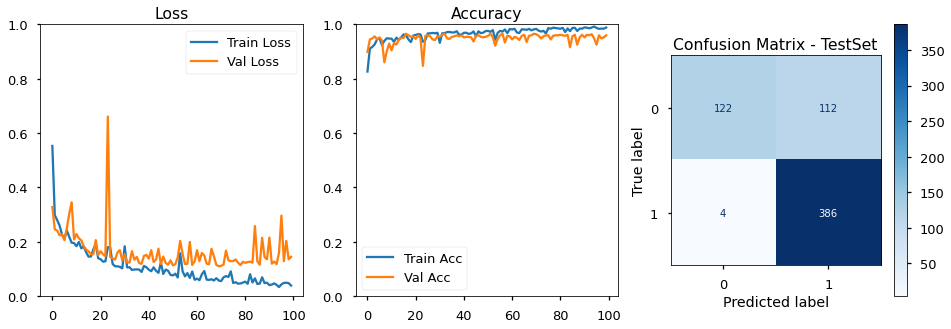

In [37]:
plot_model_performance(ann_baseline_model,train_img,test_img,"accuracy", "val_accuracy")

* The very basic ANN model with only one layer basically predicts correctly 99% of true pneumonia cases, whereas for normal cases the recall is 53%.

In [40]:
model2 = models.Sequential()

# First hidden layer
model2.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))
# Output layer
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='sgd',
             loss='binary_crossentropy',
             metrics=['accuracy'])
#The batch_size 44 is used as it is exact divisor of 4708(train data size)
ann_baseline_sgd = model2.fit(train_img, train_y, epochs = 100, batch_size = 44, verbose =0, 
                    validation_data = (val_img, val_y))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.45      0.62       234
           1       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.74       624
weighted avg       0.83      0.79      0.76       624



20/20 [==============================] - 0s 1ms/step - loss: 1.0945 - accuracy: 0.7885
--------------------------
Final Train Loss: 0.09
Final Test Loss: 1.0945
--------------------------
Final Train Acc: 0.9688
Final Test Acc: 0.7885




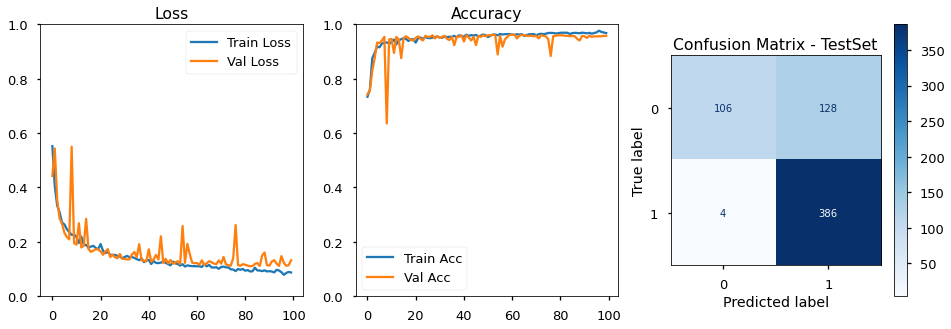

In [41]:
plot_model_performance(ann_baseline_sgd,train_img,test_img,"accuracy", "val_accuracy")

## Bigger Deeper ANN model:
* We will add an input layer with 256 neurons
* We will add four hidden layers with 128, 64, 32 and 10 neurons.
* We will add the output layer with 1 neuron.
### Early Stopping: 
* We will use early stopping for all the subsequent models. Early stopping checks the model performance on holdout validation dataset and once there is no improvement in performance, the training will stop. It helps with overfitting and it won't run for more epochs unnecessarily.
* The monitoring parameter that we will use for this will be Validation_loss.

In [42]:
# We will use patience of 10 (10 or 20 are most common). The model will wait for 10 epochs
# to make sure that there is no imporvement in model performance on Validation dataset
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

In [126]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(256, activation='relu', input_shape = (n_features,)))
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 
model.save("Deeper_ANN")
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

INFO:tensorflow:Assets written to: Deeper_ANN/assets


In [127]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 256)               12583168  
_________________________________________________________________
dense_88 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_89 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_90 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_91 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 11        
Total params: 12,626,741
Trainable params: 12,626,741
Non-trainable params: 0
_________________________________________

In [45]:
deeper_ann_model = model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=early_stopping, 
                             validation_data = (val_img, val_y))

Epoch 1/100
107/107 [==============================] - 5s 45ms/step - loss: 0.6759 - accuracy: 0.7098 - val_loss: 0.2701 - val_accuracy: 0.9103
Epoch 2/100
107/107 [==============================] - 5s 45ms/step - loss: 0.2347 - accuracy: 0.9088 - val_loss: 0.1777 - val_accuracy: 0.9275
Epoch 3/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1737 - accuracy: 0.9349 - val_loss: 0.1331 - val_accuracy: 0.9485
Epoch 4/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1300 - accuracy: 0.9467 - val_loss: 0.1538 - val_accuracy: 0.9351
Epoch 5/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1440 - accuracy: 0.9435 - val_loss: 0.1501 - val_accuracy: 0.9504
Epoch 6/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1354 - accuracy: 0.9535 - val_loss: 0.1296 - val_accuracy: 0.9523
Epoch 7/100
107/107 [==============================] - 5s 44ms/step - loss: 0.1180 - accuracy: 0.9530 - val_loss: 0.1226 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       234
           1       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624



20/20 [==============================] - 0s 5ms/step - loss: 0.2972 - accuracy: 0.8910
--------------------------
Final Train Loss: 0.1213
Final Test Loss: 0.2972
--------------------------
Final Train Acc: 0.9535
Final Test Acc: 0.891




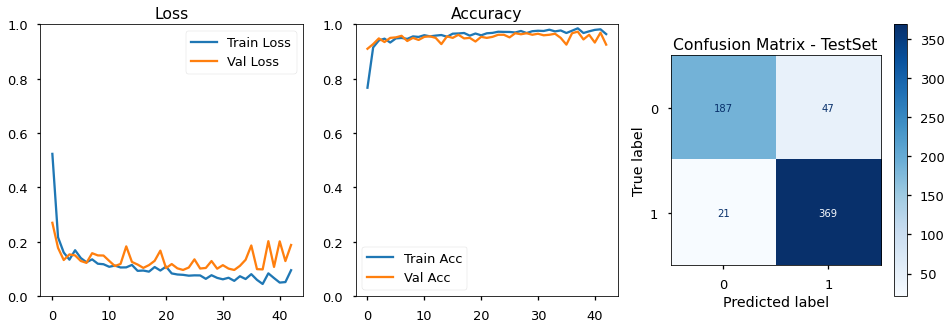

In [46]:
plot_model_performance(deeper_ann_model,train_img,test_img,"accuracy", "val_accuracy")

* The recall score for pneumonia cases is now 95%, the model misclassified 21 cases, the recall for normal cases is still not great. Compared to baseline model it though has improved from 52% to 85%.
* The test accuracy is 89% compared to train set accuracy of 95% meaning the model is slightly overfitting.
* Lets  remove the first layer with 256 neurons and see if the model does any better.
* Next steps are to include regularizations: Dropout and L2

In [47]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(128, activation='relu', input_shape = (n_features,)))
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [48]:
deeper_ann_model2 = model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=early_stopping, 
                             validation_data = (val_img, val_y))

Epoch 1/100
107/107 [==============================] - 2s 20ms/step - loss: 1.3011 - accuracy: 0.7288 - val_loss: 0.4386 - val_accuracy: 0.8034
Epoch 2/100
107/107 [==============================] - 2s 20ms/step - loss: 0.2558 - accuracy: 0.8935 - val_loss: 0.3850 - val_accuracy: 0.8454
Epoch 3/100
107/107 [==============================] - 2s 20ms/step - loss: 0.2398 - accuracy: 0.9116 - val_loss: 0.2093 - val_accuracy: 0.9179
Epoch 4/100
107/107 [==============================] - 2s 19ms/step - loss: 0.1711 - accuracy: 0.9384 - val_loss: 0.2133 - val_accuracy: 0.9103
Epoch 5/100
107/107 [==============================] - 2s 20ms/step - loss: 0.1711 - accuracy: 0.9329 - val_loss: 0.1374 - val_accuracy: 0.9427
Epoch 6/100
107/107 [==============================] - 2s 20ms/step - loss: 0.1120 - accuracy: 0.9607 - val_loss: 0.1392 - val_accuracy: 0.9466
Epoch 7/100
107/107 [==============================] - 2s 19ms/step - loss: 0.1443 - accuracy: 0.9486 - val_loss: 0.1140 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.30      0.46       234
           1       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624



20/20 [==============================] - 0s 4ms/step - loss: 1.4547 - accuracy: 0.7372
--------------------------
Final Train Loss: 0.1779
Final Test Loss: 1.4547
--------------------------
Final Train Acc: 0.928
Final Test Acc: 0.7372




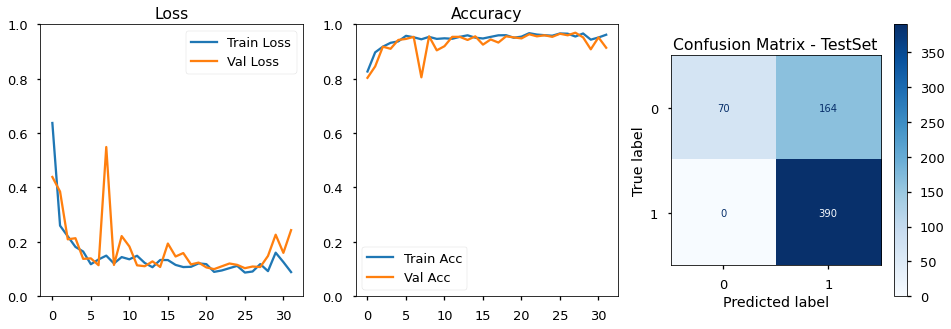

In [49]:
plot_model_performance(deeper_ann_model2,train_img,test_img,"accuracy", "val_accuracy")

* The model performed badly, so will keep the original configuration with 256 neurons in the in

## 1b. Dropout Regularization
* Apply a dropout rate of 30% to the all layers

In [50]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dropout(0.3, input_shape=(n_features,)))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dropout(0.3))

model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dropout(0.3))

model.add(layers.Dense(10, activation='relu')) 
model.add(layers.Dropout(0.3))

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 49152)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               12583168  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

In [52]:
droput_ann_model = model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 22, 
                             verbose =1,callbacks=early_stopping, 
                             validation_data = (val_img, val_y))

Epoch 1/100
214/214 [==============================] - 8s 35ms/step - loss: 3.0341 - accuracy: 0.6450 - val_loss: 0.5591 - val_accuracy: 0.7424
Epoch 2/100
214/214 [==============================] - 7s 35ms/step - loss: 0.5373 - accuracy: 0.7290 - val_loss: 0.3139 - val_accuracy: 0.7424
Epoch 3/100
214/214 [==============================] - 7s 35ms/step - loss: 0.4777 - accuracy: 0.7374 - val_loss: 0.5770 - val_accuracy: 0.7424
Epoch 4/100
214/214 [==============================] - 7s 34ms/step - loss: 0.5061 - accuracy: 0.7260 - val_loss: 0.2934 - val_accuracy: 0.7424
Epoch 5/100
214/214 [==============================] - 8s 35ms/step - loss: 0.4847 - accuracy: 0.7469 - val_loss: 0.4338 - val_accuracy: 0.7424
Epoch 6/100
214/214 [==============================] - 7s 35ms/step - loss: 0.4559 - accuracy: 0.7334 - val_loss: 0.3066 - val_accuracy: 0.7424
Epoch 7/100
214/214 [==============================] - 7s 34ms/step - loss: 0.4654 - accuracy: 0.7454 - val_loss: 0.3185 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



20/20 [==============================] - 0s 5ms/step - loss: 0.9622 - accuracy: 0.6250
--------------------------
Final Train Loss: 0.2373
Final Test Loss: 0.9622
--------------------------
Final Train Acc: 0.7421
Final Test Acc: 0.625




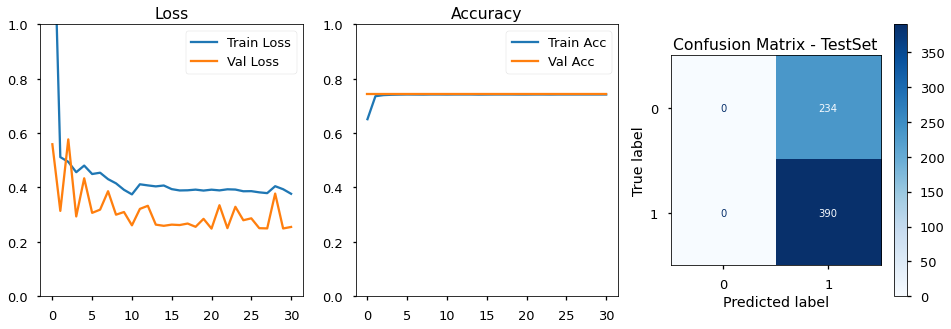

In [53]:
plot_model_performance(droput_ann_model,train_img,test_img,"accuracy", "val_accuracy")

* This model did not perform well, it mislabeled all the normal cases as pneumonia ones.

## 1c. L2 Regularization
* Lets add an L2 regularizer and see what happens

In [54]:
random.seed(123)
L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(n_features,)))

# Add another hidden layer
L2_model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
# Add another hidden layer
L2_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

L2_model.add(layers.Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))


L2_model.add(layers.Dense(1, activation='sigmoid')) 

L2_model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

# Train the model 
L2_ann_model = L2_model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=early_stopping, 
                             validation_data = (val_img, val_y))

Epoch 1/100
107/107 [==============================] - 8s 75ms/step - loss: 3.6373 - accuracy: 0.7276 - val_loss: 1.1151 - val_accuracy: 0.9027
Epoch 2/100
107/107 [==============================] - 8s 76ms/step - loss: 1.1338 - accuracy: 0.8607 - val_loss: 0.7805 - val_accuracy: 0.9256
Epoch 3/100
107/107 [==============================] - 8s 75ms/step - loss: 0.8014 - accuracy: 0.9109 - val_loss: 0.6700 - val_accuracy: 0.9504
Epoch 4/100
107/107 [==============================] - 8s 76ms/step - loss: 0.7510 - accuracy: 0.9057 - val_loss: 0.6417 - val_accuracy: 0.9485
Epoch 5/100
107/107 [==============================] - 8s 75ms/step - loss: 0.6513 - accuracy: 0.9243 - val_loss: 0.7919 - val_accuracy: 0.8779
Epoch 6/100
107/107 [==============================] - 8s 76ms/step - loss: 0.6363 - accuracy: 0.9308 - val_loss: 0.5877 - val_accuracy: 0.9256
Epoch 7/100
107/107 [==============================] - 8s 75ms/step - loss: 0.6770 - accuracy: 0.9003 - val_loss: 0.7360 - val_accuracy:

107/107 [==============================] - 8s 73ms/step - loss: 0.2401 - accuracy: 0.9506 - val_loss: 0.2643 - val_accuracy: 0.9332
Epoch 58/100
107/107 [==============================] - 8s 73ms/step - loss: 0.2085 - accuracy: 0.9549 - val_loss: 0.2279 - val_accuracy: 0.9427
Epoch 59/100
107/107 [==============================] - 8s 74ms/step - loss: 0.2414 - accuracy: 0.9408 - val_loss: 0.1942 - val_accuracy: 0.9523
Epoch 60/100
107/107 [==============================] - 8s 74ms/step - loss: 0.2212 - accuracy: 0.9526 - val_loss: 0.2095 - val_accuracy: 0.9561
Epoch 61/100
107/107 [==============================] - 8s 72ms/step - loss: 0.2278 - accuracy: 0.9488 - val_loss: 0.1985 - val_accuracy: 0.9466
Epoch 62/100
107/107 [==============================] - 8s 73ms/step - loss: 0.2155 - accuracy: 0.9524 - val_loss: 0.1921 - val_accuracy: 0.9618
Epoch 63/100
107/107 [==============================] - 8s 74ms/step - loss: 0.2253 - accuracy: 0.9454 - val_loss: 0.3948 - val_accuracy: 0.874

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.65      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.85       624



20/20 [==============================] - 0s 14ms/step - loss: 0.5024 - accuracy: 0.8606
--------------------------
Final Train Loss: 0.1777
Final Test Loss: 0.5024
--------------------------
Final Train Acc: 0.965
Final Test Acc: 0.8606




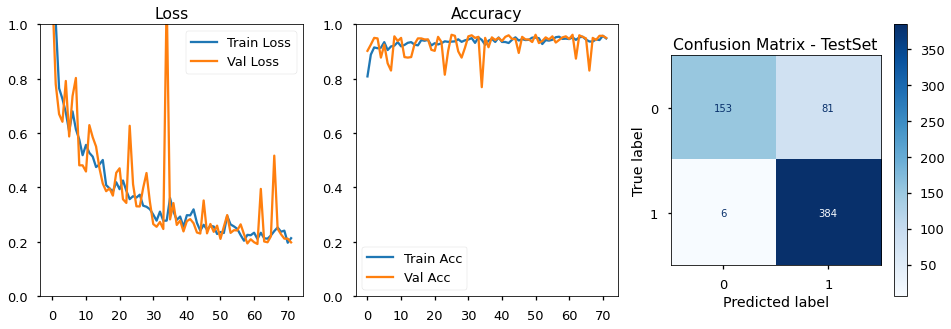

In [55]:
plot_model_performance(L2_ann_model,train_img,test_img,"accuracy", "val_accuracy")

* This performed better than the dropout version. However our basic deeper ann model performs better than all of these. So we will stci with that one as our version for ANN model

## Early stopping modified:
* Looking at the documentaion, I realized that reesults amy improve if we have weights distribution true in the early stopping. Lets implement that and see if the model improves

In [56]:
#Despite the default value of restore_weights being set to False, which helps if the model or data is large,
#We have no problem in keeping another copy of the model in memory (i.e. because it is not a  huge model),
#the most sensible value is restore_best_weights=True.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [57]:
ann_model = models.Sequential()

# Add dense layers with relu activation
ann_model.add(layers.Dense(256, activation='relu', input_shape = (n_features,)))
ann_model.add(layers.Dense(128, activation='relu')) 
ann_model.add(layers.Dense(64, activation='relu')) 
ann_model.add(layers.Dense(32, activation='relu')) 
ann_model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
ann_model.add(layers.Dense(1, activation='sigmoid')) 

ann_model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])
ann_final = ann_model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=early_stop, 
                             validation_data = (val_img, val_y))

Epoch 1/100
107/107 [==============================] - 5s 46ms/step - loss: 0.7895 - accuracy: 0.7343 - val_loss: 0.2672 - val_accuracy: 0.8893
Epoch 2/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1992 - accuracy: 0.9223 - val_loss: 0.3462 - val_accuracy: 0.8263
Epoch 3/100
107/107 [==============================] - 5s 47ms/step - loss: 0.2173 - accuracy: 0.9090 - val_loss: 0.1873 - val_accuracy: 0.9218
Epoch 4/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1910 - accuracy: 0.9292 - val_loss: 0.1257 - val_accuracy: 0.9542
Epoch 5/100
107/107 [==============================] - 5s 44ms/step - loss: 0.1193 - accuracy: 0.9529 - val_loss: 0.1250 - val_accuracy: 0.9485
Epoch 6/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1341 - accuracy: 0.9486 - val_loss: 0.1828 - val_accuracy: 0.9256
Epoch 7/100
107/107 [==============================] - 5s 45ms/step - loss: 0.1220 - accuracy: 0.9561 - val_loss: 0.1166 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.56      0.71       234
           1       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624



20/20 [==============================] - 0s 6ms/step - loss: 0.8126 - accuracy: 0.8301
--------------------------
Final Train Loss: 0.0424
Final Test Loss: 0.8126
--------------------------
Final Train Acc: 0.9845
Final Test Acc: 0.8301




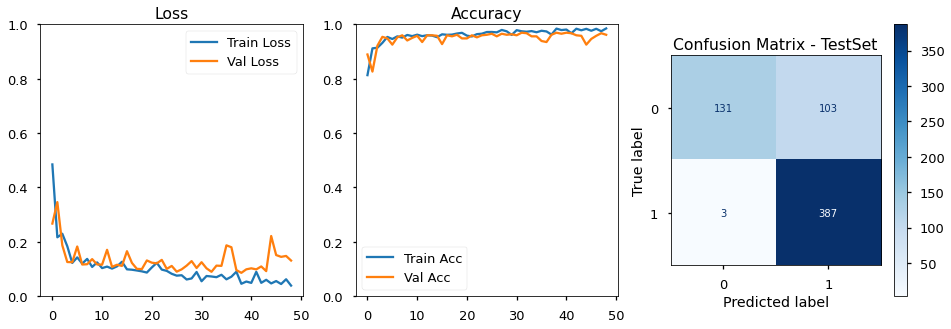

In [59]:
plot_model_performance(ann_final,train_img,test_img,"accuracy", "val_accuracy")

* This does not seem to have make much improvement
* So far, the basic deeper ann model with earlystopping (no weights) gave us the best performance

## 1d. Learning Rate Modified
 * Default learnin rate for adam is 0.001. Lets halve it and see how it works!

In [114]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(256, activation='relu', input_shape = (n_features,)))
model.add(layers.Dense(128, activation='relu')) 
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate=0.0005) , 
              metrics = ['accuracy'])

In [115]:
ann_lr = ann_model.fit(train_img, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=early_stop, 
                             validation_data = (val_img, val_y))

Epoch 1/100
107/107 [==============================] - 6s 49ms/step - loss: 0.0472 - accuracy: 0.9847 - val_loss: 0.1924 - val_accuracy: 0.9275
Epoch 2/100
107/107 [==============================] - 5s 49ms/step - loss: 0.0659 - accuracy: 0.9751 - val_loss: 0.2036 - val_accuracy: 0.9427
Epoch 3/100
107/107 [==============================] - 5s 49ms/step - loss: 0.0559 - accuracy: 0.9817 - val_loss: 0.1042 - val_accuracy: 0.9618
Epoch 4/100
107/107 [==============================] - 5s 48ms/step - loss: 0.0621 - accuracy: 0.9766 - val_loss: 0.1179 - val_accuracy: 0.9695
Epoch 5/100
107/107 [==============================] - 5s 48ms/step - loss: 0.0785 - accuracy: 0.9688 - val_loss: 0.0971 - val_accuracy: 0.9695
Epoch 6/100
107/107 [==============================] - 5s 48ms/step - loss: 0.0753 - accuracy: 0.9715 - val_loss: 0.0927 - val_accuracy: 0.9637
Epoch 7/100
107/107 [==============================] - 5s 47ms/step - loss: 0.0528 - accuracy: 0.9817 - val_loss: 0.1262 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.76       234
           1       0.81      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



20/20 [==============================] - 0s 6ms/step - loss: 0.5738 - accuracy: 0.8510
--------------------------
Final Train Loss: 0.0366
Final Test Loss: 0.5738
--------------------------
Final Train Acc: 0.9881
Final Test Acc: 0.851




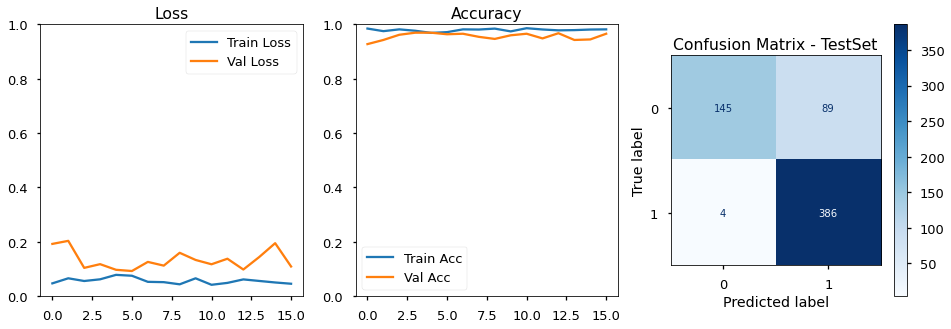

In [125]:
plot_model_performance(ann_lr,train_img,test_img,"accuracy", "val_accuracy")

# 2. Convolutional NN Model
A Convolutional Neural Network, also known as CNN or ConvNet, is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image. A CNN typically has three layers: a convolutional layer, a pooling layer, and a fully connected layer.
* The **convolution layer** is the core building block of the CNN. It carries the main portion of the network’s computational load. This layer performs a dot product between two matrices, where one matrix is the set of learnable parameters otherwise known as a kernel, and the other matrix is the restricted portion of the receptive field.
* The **pooling layer** replaces the output of the network at certain locations by deriving a summary statistic of the nearby outputs. This helps in reducing the spatial size of the representation, which decreases the required amount of computation and weights.
* Neurons in the *fully connected layer* have full connectivity with all neurons in the preceding and succeeding layer as seen in regular FCNN. This is why it can be computed as usual by a matrix multiplication followed by a bias effect.
The FC layer helps to map the representation between the input and the output.
## 2a. Baseline CNN
* Baseline model with 1 convolutional layer, 1 max pooling layer, and 1 fully connected layer
* Number of output filters in the convolutional layer is 8.
* Kernel Size is 3 x 3. If your images are smaller than 128×128 you may want to consider sticking with strictly 1×1 and 3×3 filters.

In [60]:
print(train_images.shape)
print(val_images.shape)

(4708, 128, 128, 3)
(524, 128, 128, 3)


In [61]:
cnn_model = Sequential()

# 1st Convolution and Pooling
cnn_model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3))) 
cnn_model.add(MaxPool2D(pool_size = (2, 2)))  

# Flatten
cnn_model.add(Flatten())

# Include a fully-connected layer and an output layer
cnn_model.add(Dense(activation = 'relu', units = 8)) # inner layer
cnn_model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 31752)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 254024    
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 9         
Total params: 254,257
Trainable params: 254,257
Non-trainable params: 0
_________________________________________________________________


In [62]:
baseline_cnn_model = cnn_model.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 6s 50ms/step - loss: 0.7903 - acc: 0.6662 - val_loss: 0.6725 - val_acc: 0.7424
Epoch 2/100
107/107 [==============================] - 5s 49ms/step - loss: 0.6674 - acc: 0.7408 - val_loss: 0.6525 - val_acc: 0.7424
Epoch 3/100
107/107 [==============================] - 5s 47ms/step - loss: 0.6480 - acc: 0.7428 - val_loss: 0.6360 - val_acc: 0.7424
Epoch 4/100
107/107 [==============================] - 5s 48ms/step - loss: 0.6365 - acc: 0.7283 - val_loss: 0.6223 - val_acc: 0.7424
Epoch 5/100
107/107 [==============================] - 5s 48ms/step - loss: 0.6201 - acc: 0.7404 - val_loss: 0.6110 - val_acc: 0.7424
Epoch 6/100
107/107 [==============================] - 5s 50ms/step - loss: 0.6051 - acc: 0.7502 - val_loss: 0.6020 - val_acc: 0.7424
Epoch 7/100
107/107 [==============================] - 5s 48ms/step - loss: 0.5996 - acc: 0.7431 - val_loss: 0.5947 - val_acc: 0.7424
Epoch 8/100
107/107 [==============================] - 5s 49ms

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



20/20 [==============================] - 0s 8ms/step - loss: 0.6947 - acc: 0.6250
--------------------------
Final Train Loss: 0.5708
Final Test Loss: 0.6947
--------------------------
Final Train Acc: 0.7421
Final Test Acc: 0.625




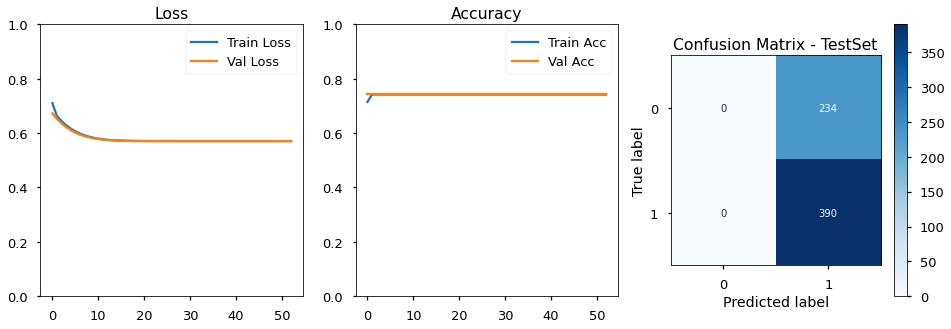

In [63]:
plot_model_performance(baseline_cnn_model,train_images,test_images, 'acc','val_acc')

 * This did not perform well either mis-labeling all the pneumonia cases

## 2b. Deeper CNN model with more layers
* An output layer with 1 neuron making the predictions.
* We will  alternate convolutional and pooling layers
* Larger number of parameters in the later layers which will help to detect more abstract patterns
* Add some final dense layers to add a classifier to the convolutional base

In [64]:
cnn_model = Sequential()

# 1st Convolution and Pooling
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))  #input_shape=(128, 128,1)
cnn_model.add(MaxPool2D(pool_size = (2, 2)))  # 32 is number of filters

# 2nd Convolution and Pooling
cnn_model.add(Conv2D(64, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution and Pooling
cnn_model.add(Conv2D(128, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))

# Flatten
cnn_model.add(Flatten())

# activation
cnn_model.add(Dense(activation = 'relu', units = 128)) # inner layer
cnn_model.add(Dense(activation = 'relu', units = 64)) # inner layer
cnn_model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

cnn_model.summary()


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [65]:
deeper_cnn_model = cnn_model.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 34s 312ms/step - loss: 0.4303 - acc: 0.8282 - val_loss: 0.1097 - val_acc: 0.9580
Epoch 2/100
107/107 [==============================] - 33s 305ms/step - loss: 0.1339 - acc: 0.9493 - val_loss: 0.0741 - val_acc: 0.9637
Epoch 3/100
107/107 [==============================] - 32s 301ms/step - loss: 0.0787 - acc: 0.9678 - val_loss: 0.0513 - val_acc: 0.9771
Epoch 4/100
107/107 [==============================] - 32s 304ms/step - loss: 0.0684 - acc: 0.9762 - val_loss: 0.0858 - val_acc: 0.9676
Epoch 5/100
107/107 [==============================] - 32s 303ms/step - loss: 0.0617 - acc: 0.9764 - val_loss: 0.0694 - val_acc: 0.9733
Epoch 6/100
107/107 [==============================] - 32s 303ms/step - loss: 0.0505 - acc: 0.9821 - val_loss: 0.0570 - val_acc: 0.9752
Epoch 7/100
107/107 [==============================] - 32s 303ms/step - loss: 0.0430 - acc: 0.9850 - val_loss: 0.0793 - val_acc: 0.9618
Epoch 8/100
107/107 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.60      0.74       234
           1       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.84      0.83       624



20/20 [==============================] - 1s 53ms/step - loss: 0.7067 - acc: 0.8446
--------------------------
Final Train Loss: 0.0148
Final Test Loss: 0.7067
--------------------------
Final Train Acc: 0.9953
Final Test Acc: 0.8446




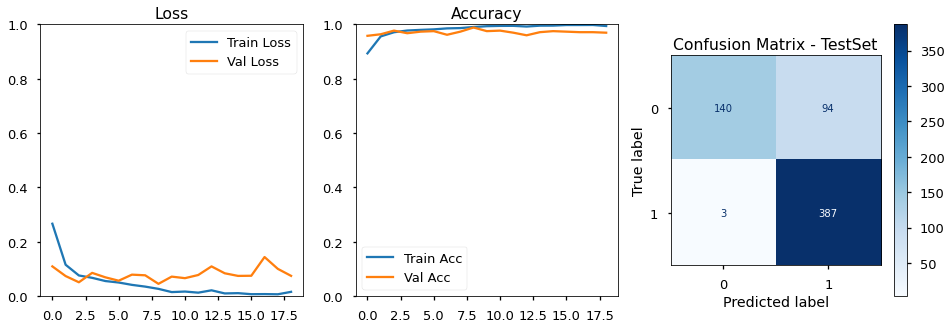

In [66]:
plot_model_performance(deeper_cnn_model,train_images,test_images, 'acc','val_acc')

* Even though the peneumonia prediction rate is 99%, only 3 cases are mis-labeled, but the normal cases are mis-labeled 40% of the time.
* There may be some overfitting as test and train accuracy differ by 15%.
* Let's implement dropout and see if that helps with overfitting

In [70]:
#cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
#deeper_cnn_model2 = cnn_model.fit(train_images, train_y, 
#                             epochs = 100, batch_size = 44, 
#                             verbose =1,callbacks=[early_stopping], 
#                             validation_data = (val_images, val_y))

In [69]:
#plot_model_performance(deeper_cnn_model2,train_images,test_images, 'acc','val_acc')

### CNN with Dropout regularization

In [71]:
cnn_model = Sequential()

# 1st Convolution and Pooling and dropout
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
cnn_model.add(MaxPool2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.3)) # regularization, turn off 40% of the neurons

# 2nd Convolution and Pooling
cnn_model.add(Conv2D(64, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.3)) # regularization

# 3rd Convolution and Pooling
cnn_model.add(Conv2D(128, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))
cnn_model.add(Dropout(0.3)) # regularization

# Flatten
cnn_model.add(Flatten())

cnn_model.add(Dense(activation = 'relu', units = 128)) # inner layer
cnn_model.add(Dropout(0.1)) # regularization
cnn_model.add(Dense(activation = 'relu', units = 64)) # inner layer
cnn_model.add(Dropout(0.1)) # regularization
cnn_model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

cnn_model.save("Dropout_CNN")

# Compile model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

cnn_model.summary()

INFO:tensorflow:Assets written to: Dropout_CNN/assets
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________

In [72]:
dropout_cnn_model = cnn_model.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 38s 345ms/step - loss: 0.6392 - acc: 0.7139 - val_loss: 0.1949 - val_acc: 0.9313
Epoch 2/100
107/107 [==============================] - 37s 349ms/step - loss: 0.1946 - acc: 0.9174 - val_loss: 0.1334 - val_acc: 0.9542
Epoch 3/100
107/107 [==============================] - 36s 340ms/step - loss: 0.1467 - acc: 0.9434 - val_loss: 0.1266 - val_acc: 0.9561
Epoch 4/100
107/107 [==============================] - 37s 343ms/step - loss: 0.1303 - acc: 0.9541 - val_loss: 0.0936 - val_acc: 0.9580
Epoch 5/100
107/107 [==============================] - 38s 351ms/step - loss: 0.1006 - acc: 0.9667 - val_loss: 0.0750 - val_acc: 0.9733
Epoch 6/100
107/107 [==============================] - 38s 352ms/step - loss: 0.0742 - acc: 0.9735 - val_loss: 0.0943 - val_acc: 0.9676
Epoch 7/100
107/107 [==============================] - 37s 345ms/step - loss: 0.0696 - acc: 0.9748 - val_loss: 0.0634 - val_acc: 0.9771
Epoch 8/100
107/107 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.73       234
           1       0.80      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.79      0.81       624
weighted avg       0.87      0.84      0.83       624



20/20 [==============================] - 1s 56ms/step - loss: 0.6597 - acc: 0.8413
--------------------------
Final Train Loss: 0.0291
Final Test Loss: 0.6597
--------------------------
Final Train Acc: 0.9904
Final Test Acc: 0.8413




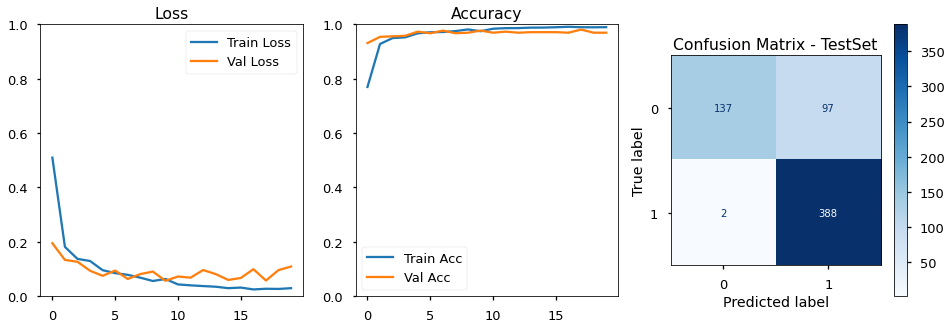

In [73]:
plot_model_performance(dropout_cnn_model,train_images,test_images, 'acc','val_acc')

* We do not see any significant improvemement in this version of model.

# 3. Transfer Learning Approach: Models using pre-trained modules
* There are various pre-trained models that are now a days used for image classification. These as a part of transfer learning approach(https://keras.io/guides/transfer_learning/). Shown below is the list of most commonly used pre-trained modules:

    * Resnet18, Resnet34, Resnet50 and Resnet101
    * VGG16 and VGG19
    * EfficientNet
    * Inception
    * Xception
    
### Here is the list of steps that we will follow to use these models    
* Instantiate a base model and load pre-trained weights into it.
* Freeze all layers in the base model by setting trainable = False.
* Change the image size from the input layer so we can use the model on our images: (128, 128, 3)
* Create a new model on top of the output of one (or several) layers from the base model.
* Add a global pooling layer = 'avg' rather than flattening the image.
* Train this new model on our dataset.

## In this exercise we will use Resnet101 and Xception
## 3a. Xception

In [74]:
from keras.applications import Xception

In [75]:
Xception().summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [76]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(128, 128, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [77]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1,activation = "sigmoid")(x)
transfer_model = keras.Model(inputs, outputs)

# Add the fully connected layers
#transfer_model.add(Dense(1, activation = "sigmoid"))

transfer_model.summary()
transfer_model.save("XceptionD");

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________
INFO:tensorflow:Assets written to: XceptionD/assets


In [78]:
transfer_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [79]:
xception_model = transfer_model.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 58s 528ms/step - loss: 0.3241 - accuracy: 0.8648 - val_loss: 0.2219 - val_accuracy: 0.9065
Epoch 2/100
107/107 [==============================] - 56s 528ms/step - loss: 0.1785 - accuracy: 0.9262 - val_loss: 0.1873 - val_accuracy: 0.9237
Epoch 3/100
107/107 [==============================] - 56s 520ms/step - loss: 0.1529 - accuracy: 0.9423 - val_loss: 0.1749 - val_accuracy: 0.9370
Epoch 4/100
107/107 [==============================] - 56s 523ms/step - loss: 0.1366 - accuracy: 0.9489 - val_loss: 0.1610 - val_accuracy: 0.9370
Epoch 5/100
107/107 [==============================] - 56s 524ms/step - loss: 0.1257 - accuracy: 0.9544 - val_loss: 0.1628 - val_accuracy: 0.9427
Epoch 6/100
107/107 [==============================] - 55s 516ms/step - loss: 0.1225 - accuracy: 0.9530 - val_loss: 0.1538 - val_accuracy: 0.9427
Epoch 7/100
107/107 [==============================] - 56s 519ms/step - loss: 0.1174 - accuracy: 0.9554 - val_loss: 0.1597 -

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.69      0.80       234
           1       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.89      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



20/20 [==============================] - 6s 296ms/step - loss: 0.3529 - accuracy: 0.8702
--------------------------
Final Train Loss: 0.0581
Final Test Loss: 0.3529
--------------------------
Final Train Acc: 0.9843
Final Test Acc: 0.8702




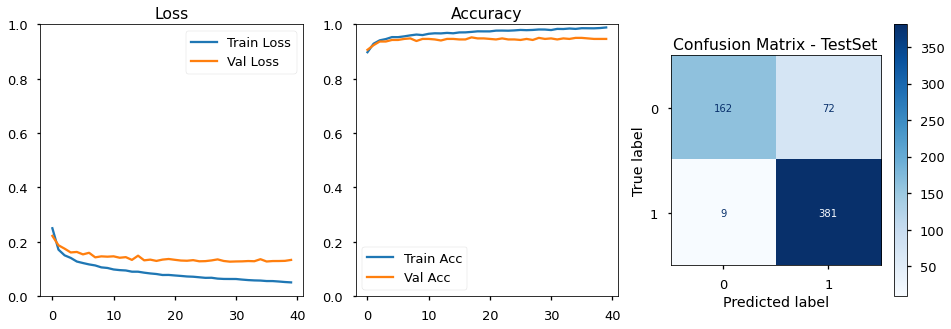

In [80]:
plot_model_performance(xception_model,train_images,test_images, 'accuracy','val_accuracy')

In [81]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1,activation = "sigmoid")(x)
transfer_model = keras.Model(inputs, outputs)

model = Sequential()
model.add(transfer_model)

# Add the fully connected layers
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(1, activation = "sigmoid"))

model.summary()
model.save("XceptionD_deep");

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 1)                 20863529  
_________________________________________________________________
dense_45 (Dense)             (None, 128)               256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 65        
Total params: 20,872,106
Trainable params: 10,626
Non-trainable params: 20,861,480
____________________________________

In [82]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [83]:
xception_model_deep = model.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 55s 506ms/step - loss: 0.5323 - accuracy: 0.7227 - val_loss: 0.2999 - val_accuracy: 0.9008
Epoch 2/100
107/107 [==============================] - 53s 495ms/step - loss: 0.2672 - accuracy: 0.9226 - val_loss: 0.2684 - val_accuracy: 0.9122
Epoch 3/100
107/107 [==============================] - 53s 499ms/step - loss: 0.2456 - accuracy: 0.9247 - val_loss: 0.2297 - val_accuracy: 0.9370
Epoch 4/100
107/107 [==============================] - 53s 497ms/step - loss: 0.2060 - accuracy: 0.9430 - val_loss: 0.2138 - val_accuracy: 0.9389
Epoch 5/100
107/107 [==============================] - 53s 497ms/step - loss: 0.1735 - accuracy: 0.9543 - val_loss: 0.1946 - val_accuracy: 0.9294
Epoch 6/100
107/107 [==============================] - 56s 521ms/step - loss: 0.1775 - accuracy: 0.9503 - val_loss: 0.2040 - val_accuracy: 0.9160
Epoch 7/100
107/107 [==============================] - 53s 498ms/step - loss: 0.1484 - accuracy: 0.9577 - val_loss: 0.2170 -

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.66      0.77       234
           1       0.83      0.97      0.89       390

    accuracy                           0.86       624
   macro avg       0.88      0.82      0.83       624
weighted avg       0.87      0.86      0.85       624



20/20 [==============================] - 6s 317ms/step - loss: 0.5213 - accuracy: 0.8558
--------------------------
Final Train Loss: 0.061
Final Test Loss: 0.5213
--------------------------
Final Train Acc: 0.9807
Final Test Acc: 0.8558




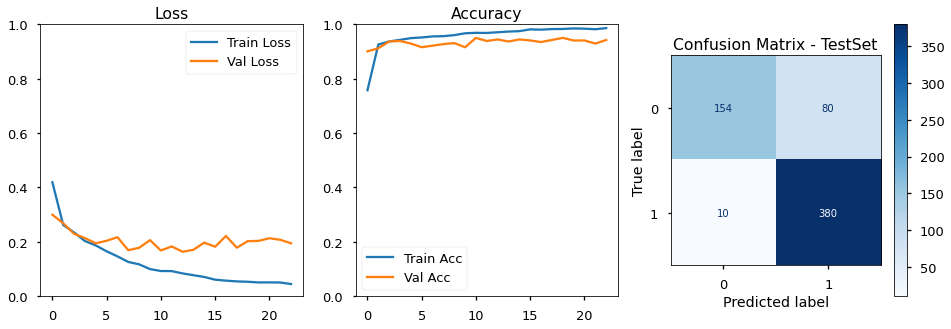

In [84]:
plot_model_performance(xception_model_deep,train_images,test_images, 'accuracy','val_accuracy')

## 3b. RESNET101

In [85]:
from keras.applications.resnet import ResNet101
ResNet101().summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [86]:
resnet_model = keras.applications.ResNet101(weights = "imagenet",
                                            input_shape = (128, 128, 3),
                                            pooling="avg", include_top = False,
                                            classes = 2)

resnet_model.trainable = False
resnet_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [87]:
RESmodel = Sequential()
RESmodel.add(resnet_model)

# Add the fully connected layers
RESmodel.add(Dense(1, activation = "sigmoid"))

RESmodel.summary()
RESmodel.save("RESNET101");
RESmodel.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 2049      
Total params: 42,660,225
Trainable params: 2,049
Non-trainable params: 42,658,176
_________________________________________________________________
INFO:tensorflow:Assets written to: RESNET101/assets


In [88]:
resnet101_model = RESmodel.fit(train_images, train_y, 
                             epochs = 100, batch_size = 44, 
                             verbose =1,callbacks=[early_stop], 
                             validation_data = (val_images, val_y))

Epoch 1/100
107/107 [==============================] - 119s 1s/step - loss: 0.5773 - accuracy: 0.7362 - val_loss: 0.5376 - val_accuracy: 0.7424
Epoch 2/100
107/107 [==============================] - 113s 1s/step - loss: 0.5199 - accuracy: 0.7511 - val_loss: 0.5067 - val_accuracy: 0.7424
Epoch 3/100
107/107 [==============================] - 114s 1s/step - loss: 0.5012 - accuracy: 0.7395 - val_loss: 0.4790 - val_accuracy: 0.7424
Epoch 4/100
107/107 [==============================] - 113s 1s/step - loss: 0.4618 - accuracy: 0.7523 - val_loss: 0.4552 - val_accuracy: 0.7519
Epoch 5/100
107/107 [==============================] - 113s 1s/step - loss: 0.4516 - accuracy: 0.7590 - val_loss: 0.4363 - val_accuracy: 0.7901
Epoch 6/100
107/107 [==============================] - 114s 1s/step - loss: 0.4290 - accuracy: 0.7837 - val_loss: 0.4159 - val_accuracy: 0.7901
Epoch 7/100
107/107 [==============================] - 114s 1s/step - loss: 0.4150 - accuracy: 0.7979 - val_loss: 0.4001 - val_accuracy:

107/107 [==============================] - 113s 1s/step - loss: 0.2416 - accuracy: 0.9011 - val_loss: 0.2191 - val_accuracy: 0.9046
Epoch 58/100
107/107 [==============================] - 113s 1s/step - loss: 0.2234 - accuracy: 0.9105 - val_loss: 0.2183 - val_accuracy: 0.9046
Epoch 59/100
107/107 [==============================] - 112s 1s/step - loss: 0.2302 - accuracy: 0.9084 - val_loss: 0.2173 - val_accuracy: 0.9046
Epoch 60/100
107/107 [==============================] - 112s 1s/step - loss: 0.2342 - accuracy: 0.8995 - val_loss: 0.2162 - val_accuracy: 0.9046
Epoch 61/100
107/107 [==============================] - 115s 1s/step - loss: 0.2311 - accuracy: 0.9055 - val_loss: 0.2152 - val_accuracy: 0.9046
Epoch 62/100
107/107 [==============================] - 116s 1s/step - loss: 0.2256 - accuracy: 0.9086 - val_loss: 0.2151 - val_accuracy: 0.9027
Epoch 63/100
107/107 [==============================] - 113s 1s/step - loss: 0.2332 - accuracy: 0.9046 - val_loss: 0.2141 - val_accuracy: 0.906

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.59      0.73       234
           1       0.80      0.98      0.88       390

    accuracy                           0.83       624
   macro avg       0.87      0.79      0.80       624
weighted avg       0.85      0.83      0.82       624



20/20 [==============================] - 14s 695ms/step - loss: 0.3782 - accuracy: 0.8333
--------------------------
Final Train Loss: 0.2038
Final Test Loss: 0.3782
--------------------------
Final Train Acc: 0.9182
Final Test Acc: 0.8333




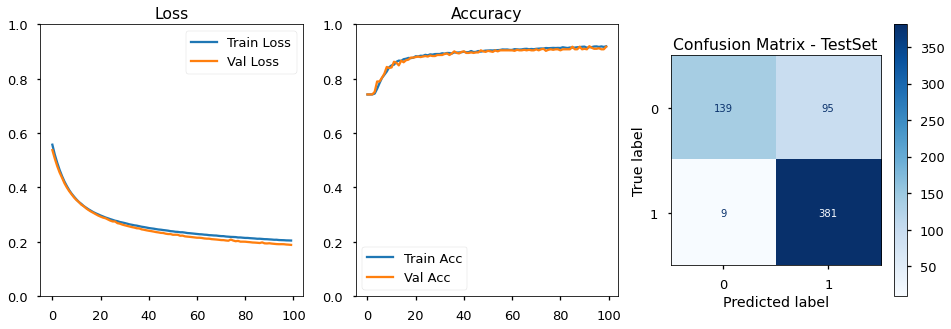

In [89]:
plot_model_performance(resnet101_model,train_images,test_images, 'accuracy','val_accuracy')

* Again we have better identification for pneumonia cases but normal cases get mis-labelled 40% of the time.
* I would like to experiment data augmentation and see if it helps improve model performance.
* The simplest Xception model performed better in the category of transfer learning models, so I would only use for Data Augmentation studies

# 4. Data Augmentation

In [90]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

In [91]:
# Since we have 4708 images in train set, I set a batch size of 214(divisor of 4708), which means that we
#will need 22 steps in our model training to go over all 4708 images
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(128, 128), 
        batch_size = 214, #128
        class_mode='binary')
# get all the data in the directory split/validation  and reshape them
# we have 524 images, so choosing 131 (divisor of 524) and we will have 4 validation steps in training
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(128, 128),
        batch_size = 131,#20
        class_mode='binary')

# get all the data in the directory split/train , and reshape them
# I keep it at 624 same as the number of images in test dataset
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(128, 128), 
        batch_size = 624, #156#20
        class_mode='binary')

Found 4708 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [148]:
Xtest_aug, ytest_aug = next(test_generator)
Xtrain_aug, ytrain_aug = next(train_generator)
Xval_aug, yval_aug = next(val_generator)

In [149]:
Xtrain_aug_v = Xtrain_aug.reshape(Xtrain_aug.shape[0], -1)
Xtest_aug_v  = Xtest_aug.reshape(Xtest_aug.shape[0], -1)
Xval_aug_v   = Xval_aug.reshape(Xval_aug.shape[0], -1)

In [151]:
Xtrain_aug_v.shape

(214, 49152)

In [152]:
ytrain_aug_v = np.reshape(ytrain_aug, (ytrain_aug.shape[0],1))
ytest_aug_v = np.reshape(ytest_aug, (ytest_aug.shape[0],1))
yval_aug_v = np.reshape(yval_aug, (yval_aug.shape[0],1))

In [94]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1,activation = "sigmoid")(x)
transfer_model = keras.Model(inputs, outputs)

# Add the fully connected layers
#transfer_model.add(Dense(1, activation = "sigmoid"))

transfer_model.summary()
#transfer_model.save("XceptionD");
transfer_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [95]:
xception_aug = transfer_model.fit(train_generator, 
                              steps_per_epoch=22, #25
                              epochs=100, 
                              validation_data=val_generator, 
                              validation_steps=4, callbacks=[early_stop])#20

Epoch 1/100
22/22 [==============================] - 87s 4s/step - loss: 0.4599 - accuracy: 0.7890 - val_loss: 0.3526 - val_accuracy: 0.8569
Epoch 2/100
22/22 [==============================] - 83s 4s/step - loss: 0.2890 - accuracy: 0.8809 - val_loss: 0.3065 - val_accuracy: 0.8798
Epoch 3/100
22/22 [==============================] - 84s 4s/step - loss: 0.2433 - accuracy: 0.9033 - val_loss: 0.2993 - val_accuracy: 0.8798
Epoch 4/100
22/22 [==============================] - 83s 4s/step - loss: 0.2404 - accuracy: 0.8971 - val_loss: 0.2757 - val_accuracy: 0.8836
Epoch 5/100
22/22 [==============================] - 84s 4s/step - loss: 0.2214 - accuracy: 0.9086 - val_loss: 0.2694 - val_accuracy: 0.8855
Epoch 6/100
22/22 [==============================] - 87s 4s/step - loss: 0.2085 - accuracy: 0.9176 - val_loss: 0.2436 - val_accuracy: 0.8950
Epoch 7/100
22/22 [==============================] - 85s 4s/step - loss: 0.2016 - accuracy: 0.9194 - val_loss: 0.2572 - val_accuracy: 0.8931
Epoch 8/100
2

In [96]:
#test_loss, test_acc = xception_aug.model.evaluate(test_generator, steps=30)
test_loss, test_acc = xception_aug.model.evaluate(Xtest_aug, ytest_aug)
print('test acc:', test_acc)

20/20 [==============================] - 7s 314ms/step - loss: 0.2888 - accuracy: 0.8622
test acc: 0.8621794581413269


In [105]:
# Model evaluation function for augmented data
def aug_model_performance(Model, Xtrain, Xtest, Acc, Val_acc):
    
    with plt.style.context('seaborn-talk'):
        
        # Diplay train and validation loss and accuracy:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
        ax1.plot(Model.history['loss'])
        ax1.plot(Model.history['val_loss'])
        ax1.set_title("Loss")
        ax1.legend(labels = ['Train Loss', 'Val Loss'])
        ax1.set_ylim(0,1)
        ax2.plot(Model.history[Acc])
        ax2.plot(Model.history[Val_acc])
        ax2.legend(labels = ['Train Acc', 'Val Acc'])
        ax2.set_title('Accuracy')
        ax2.set_ylim(0,1)

        # Output (probability) predictions for the test set 
        y_hat_test = Model.model.predict(Xtest_aug)
        y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
        y_true = ytest_aug.astype(np.int)
    
        # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax3)
        ax3.set_title('Confusion Matrix - TestSet')

        # Print Classification Report displaying the performance of the model on the test set using various metrics:
        print('Classification Report:')
        print(classification_report(y_true, y_pred))
        print('\n')

        # Print final train and test loss and accuracy:
        train_loss, train_acc = Model.model.evaluate(Xtrain, ytrain_aug);
        test_loss, test_acc = Model.model.evaluate(Xtest, ytest_aug);
        print('--------------------------')
        print(f'Final Train Loss: {np.round(train_loss,4)}')
        print(f'Final Test Loss: {np.round(test_loss,4)}') 
        print('--------------------------')
        print(f'Final Train Acc: {np.round(train_acc,4)}')
        print(f'Final Test Acc: {np.round(test_acc,4)}') 
        print('\n')

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.79       234
           1       0.84      0.96      0.90       390

    accuracy                           0.86       624
   macro avg       0.88      0.83      0.84       624
weighted avg       0.87      0.86      0.86       624



20/20 [==============================] - 6s 315ms/step - loss: 0.2888 - accuracy: 0.8622
--------------------------
Final Train Loss: 0.1682
Final Test Loss: 0.2888
--------------------------
Final Train Acc: 0.9393
Final Test Acc: 0.8622




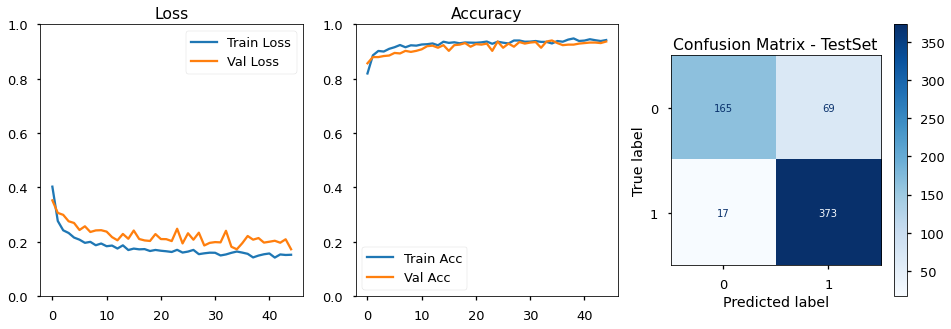

In [98]:
aug_model_performance(xception_aug,Xtrain_aug,Xtest_aug, 'accuracy','val_accuracy')

In [99]:
#plot_model_performance(xception_aug,train_images,test_images, 'accuracy','val_accuracy')

In [100]:
inputs = keras.Input(shape=(128, 128, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1,activation = "sigmoid")(x)
transfer_model = keras.Model(inputs, outputs)

model = Sequential()
model.add(transfer_model)
#transfer_model.Flatten()

# Add the fully connected layers
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(1, activation = "sigmoid"))

model.summary()
model.save("XceptionD_deep_aug");

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 1)                 20863529  
_________________________________________________________________
dense_51 (Dense)             (None, 128)               256       
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_14 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 65        
Total params: 20,872,106
Trainable params: 10,626
Non-trainable params: 20,861,480
____________________________________

In [101]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
xception_aug_deep = model.fit(train_generator, 
                              steps_per_epoch=22, 
                              epochs=100, 
                              validation_data=val_generator, 
                              validation_steps=4, callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 85s 4s/step - loss: 0.6453 - accuracy: 0.6761 - val_loss: 0.5123 - val_accuracy: 0.7424
Epoch 2/100
22/22 [==============================] - 82s 4s/step - loss: 0.4915 - accuracy: 0.7404 - val_loss: 0.4176 - val_accuracy: 0.7424
Epoch 3/100
22/22 [==============================] - 81s 4s/step - loss: 0.3868 - accuracy: 0.7400 - val_loss: 0.3349 - val_accuracy: 0.7424
Epoch 4/100
22/22 [==============================] - 82s 4s/step - loss: 0.3126 - accuracy: 0.7621 - val_loss: 0.3076 - val_accuracy: 0.8989
Epoch 5/100
22/22 [==============================] - 82s 4s/step - loss: 0.2910 - accuracy: 0.8849 - val_loss: 0.3059 - val_accuracy: 0.8874
Epoch 6/100
22/22 [==============================] - 81s 4s/step - loss: 0.2794 - accuracy: 0.9172 - val_loss: 0.2934 - val_accuracy: 0.8931
Epoch 7/100
22/22 [==============================] - 82s 4s/step - loss: 0.2691 - accuracy: 0.9141 - val_loss: 0.2861 - val_accuracy: 0.9046
Epoch 8/100
2

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       234
           1       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



20/20 [==============================] - 6s 305ms/step - loss: 0.2715 - accuracy: 0.9022
--------------------------
Final Train Loss: 0.163
Final Test Loss: 0.2715
--------------------------
Final Train Acc: 0.9363
Final Test Acc: 0.9022




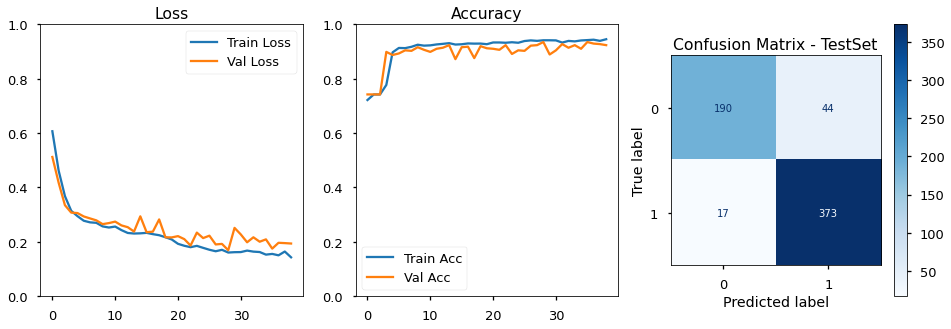

In [102]:
plot_model_performance(xception_aug_deep,train_images,test_images, 'accuracy','val_accuracy')

* The model performance has improved and test and train accuracies are much closer indicating no overfitting

## CNN model with Augmented data:
* For completeness/curosity lets check how the CNN deeper model performs on the augmented data

In [192]:
cnn_model = Sequential()

# 1st Convolution and Pooling
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))  #input_shape=(128, 128,1)
cnn_model.add(MaxPool2D(pool_size = (2, 2)))  # 32 is number of filters

# 2nd Convolution and Pooling
cnn_model.add(Conv2D(64, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution and Pooling
cnn_model.add(Conv2D(128, (3, 3), activation="relu"))
cnn_model.add(MaxPool2D(pool_size = (2, 2)))

# Flatten
cnn_model.add(Flatten())

# activation
cnn_model.add(Dense(activation = 'relu', units = 128)) # inner layer
cnn_model.add(Dense(activation = 'relu', units = 64)) # inner layer
cnn_model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
#cnn_model.summary()
cnn_model.save("CNN_DEEP_AUG");

INFO:tensorflow:Assets written to: CNN_DEEP_AUG/assets


In [122]:
aug_cnn_deep = cnn_model.fit(train_generator, 
                              steps_per_epoch=22, 
                              epochs=100, 
                              validation_data=val_generator, 
                              validation_steps=4, callbacks=[early_stop])

Epoch 1/100
22/22 [==============================] - 73s 3s/step - loss: 0.5034 - acc: 0.7583 - val_loss: 0.5933 - val_acc: 0.7481
Epoch 2/100
22/22 [==============================] - 72s 3s/step - loss: 0.4165 - acc: 0.8037 - val_loss: 0.3982 - val_acc: 0.8244
Epoch 3/100
22/22 [==============================] - 71s 3s/step - loss: 0.3463 - acc: 0.8379 - val_loss: 0.2668 - val_acc: 0.8645
Epoch 4/100
22/22 [==============================] - 71s 3s/step - loss: 0.3149 - acc: 0.8571 - val_loss: 0.2428 - val_acc: 0.8874
Epoch 5/100
22/22 [==============================] - 72s 3s/step - loss: 0.2715 - acc: 0.8857 - val_loss: 0.2373 - val_acc: 0.8931
Epoch 6/100
22/22 [==============================] - 73s 3s/step - loss: 0.2648 - acc: 0.8870 - val_loss: 0.2291 - val_acc: 0.8989
Epoch 7/100
22/22 [==============================] - 71s 3s/step - loss: 0.2501 - acc: 0.8921 - val_loss: 0.1643 - val_acc: 0.9466
Epoch 8/100
22/22 [==============================] - 70s 3s/step - loss: 0.2252 - a

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86       234
           1       0.88      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.88      0.90       624
weighted avg       0.92      0.91      0.90       624



20/20 [==============================] - 1s 59ms/step - loss: 0.2481 - acc: 0.9071
--------------------------
Final Train Loss: 0.1066
Final Test Loss: 0.2481
--------------------------
Final Train Acc: 0.9571
Final Test Acc: 0.9071




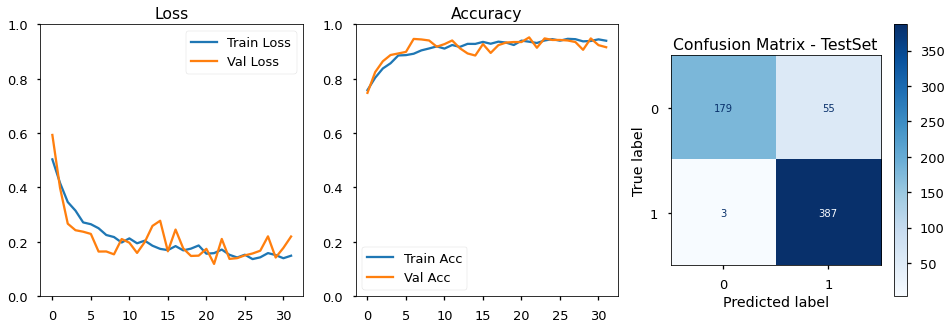

In [124]:
plot_model_performance(aug_cnn_deep,train_images,test_images, 'acc','val_acc')

In [205]:
cnn_model.save("aug_cnn_deep.h5")

In [183]:
#aug_cnn_deepR = cnn_model.fit(train_generator, 
#                              steps_per_epoch=22, 
#                              epochs=100, 
#                              validation_data=val_generator, 
#                              validation_steps=4, callbacks=[early_stop])

In [182]:
#plot_model_performance(aug_cnn_deepR,train_images,test_images, 'acc','val_acc')

* The model with augmentated data has performed better as compared to the same model that was trained on data.

# Two Best Models
* We want the models that that have high recall for pneumonia as we do not want pneumonia cases to be mis-labeled. Keeping this in mind, the CNN deeper model on augmented data set gives the best results (99% recall rate), with only 3 pneumonia cases as mis-labeled. The recall for normal cases is about 76% in this case
* The second best model following the same metrics is Xception model again on augmented dataset. I chose this model because it has somewhat better recall for normal cases (81%) with a slight decrease in recall for pneumonia cases (96%).

In [170]:
train_acc_cnn_aug = np.round(aug_cnn_deep.model.evaluate(train_images, train_labels)[1],3)
val_acc_cnn_aug = np.round(aug_cnn_deep.model.evaluate(val_images, val_labels)[1],3)
test_acc_cnn_aug = np.round(aug_cnn_deep.model.evaluate(test_images, test_labels)[1],3)

train_acc_xception_aug = np.round(xception_aug_deep.model.evaluate(train_images, train_labels)[1],3)
val_acc_xcseption_aug = np.round(xception_aug_deep.model.evaluate(val_images, val_labels)[1],3)
test_acc_cnn_aug = np.round(xception_aug_deep.model.evaluate(test_images, test_labels)[1],3)

20/20 [==============================] - 7s 346ms/step - loss: 0.2715 - accuracy: 0.9022


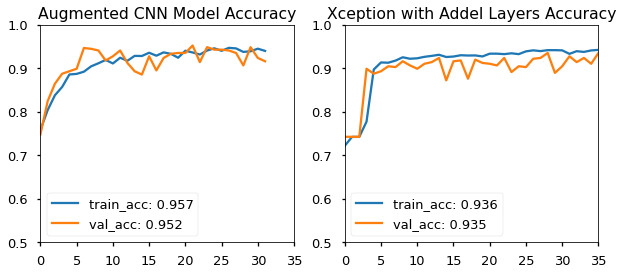

In [430]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))  
    
    ax1.plot(aug_cnn_deep.history['acc'])
    ax1.plot(aug_cnn_deep.history['val_acc'])
    ax1.set_title('Augmented CNN Model Accuracy')
    ax1.legend(labels = [f'train_acc: {train_acc_cnn_aug}', f'val_acc: {val_acc_cnn_aug}'])
    ax1.set_ylim([0.50, 1])
    ax1.set_xlim([0, 35])
    
    ax2.plot(xception_aug_deep.history['accuracy'])
    ax2.plot(xception_aug_deep.history['val_accuracy'])
    ax2.set_title('Xception with Addel Layers Accuracy')
    ax2.legend(labels = [f'train_acc: {train_acc_xception_aug}', f'val_acc: {val_acc_xcseption_aug}'])
    ax2.set_ylim([0.50, 1])
    ax2.set_xlim([0, 35])
    

    
plt.savefig('./images/accuracy_top_two_models_comp.png', dpi=300, bbox_inches='tight')

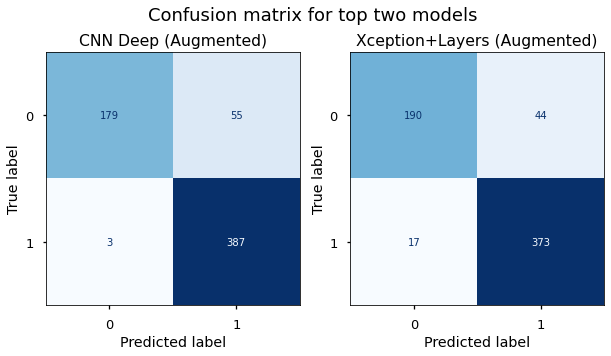

In [431]:
with plt.style.context('seaborn-talk'):
 
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle("Confusion matrix for top two models \n", fontsize=18)
    
    for ax, result, modelname in zip(axs.ravel(),[aug_cnn_deep,xception_aug_deep],['CNN Deep (Augmented)','Xception+Layers (Augmented)']):
        y_hat_test = result.model.predict(test_images)
        y_pred = np.rint(y_hat_test).astype(np.int) 
        y_true = test_y.astype(np.int)
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax, colorbar =False)
        ax.set_title(modelname) 
plt.savefig('./images/TopModels_CM.png', dpi=300, bbox_inches='tight')

In [103]:
#model_train = keras.models.load_model("XceptionD_deep_aug")

In [255]:
#!pip install lime

In [245]:
import lime
from lime import lime_tabular

In [253]:
#explainer = lime_tabular.LimeTabularExplainer(
#    training_data=np.array(train_img),
#    feature_names=train_y.tolist(),
#    class_names=['Normal', 'Pneumonia'],
#    mode='classification'
#)

In [254]:
#train_y.tolist()
#train_img

# Feature Extraction

### Visualizing a Layer

* In order to get a better sense of what representations our CNN is learning under the hood, we will visualize the feature maps generated during training. 
* CNNs work by applying a filter successively over an image. This transformation creates a new representation of the image which we call a feature map.

In [206]:
best_model = keras.models.load_model("aug_cnn_deep.h5")
best_model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)           

(1, 128, 128, 3)


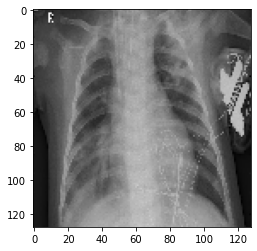

In [378]:
# Lets just Visulaize one image
# Display the image
filename = 'train/PNEUMONIA/BACTERIA-8705009-0002.jpeg'
img = image.load_img(filename, target_size=(128, 128))
img_tensor = image.img_to_array(img)

# reshape the image into tensor to be able to use with the CNN architecture:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview the image
plt.imshow(img_tensor[0])
plt.show()

* Now lets visulaize the forst activation layer and see the third channel

(1, 126, 126, 32)


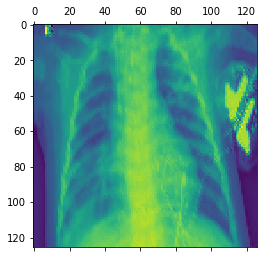

In [380]:
layer_outputs = [layer.output for layer in best_model.layers[:6]]
# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs)
activations = activation_model(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

In [381]:
layer_outputs

[<KerasTensor: shape=(None, 126, 126, 32) dtype=float32 (created by layer 'conv2d_21')>,
 <KerasTensor: shape=(None, 63, 63, 32) dtype=float32 (created by layer 'max_pooling2d_13')>,
 <KerasTensor: shape=(None, 61, 61, 64) dtype=float32 (created by layer 'conv2d_22')>,
 <KerasTensor: shape=(None, 30, 30, 64) dtype=float32 (created by layer 'max_pooling2d_14')>,
 <KerasTensor: shape=(None, 28, 28, 128) dtype=float32 (created by layer 'conv2d_23')>,
 <KerasTensor: shape=(None, 14, 14, 128) dtype=float32 (created by layer 'max_pooling2d_15')>]

In [382]:
best_model.input

<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'conv2d_21_input')>

### Visualize all 32 of the channels from the first activation function.
* The initial three layers output feature maps that have 32 channels each.

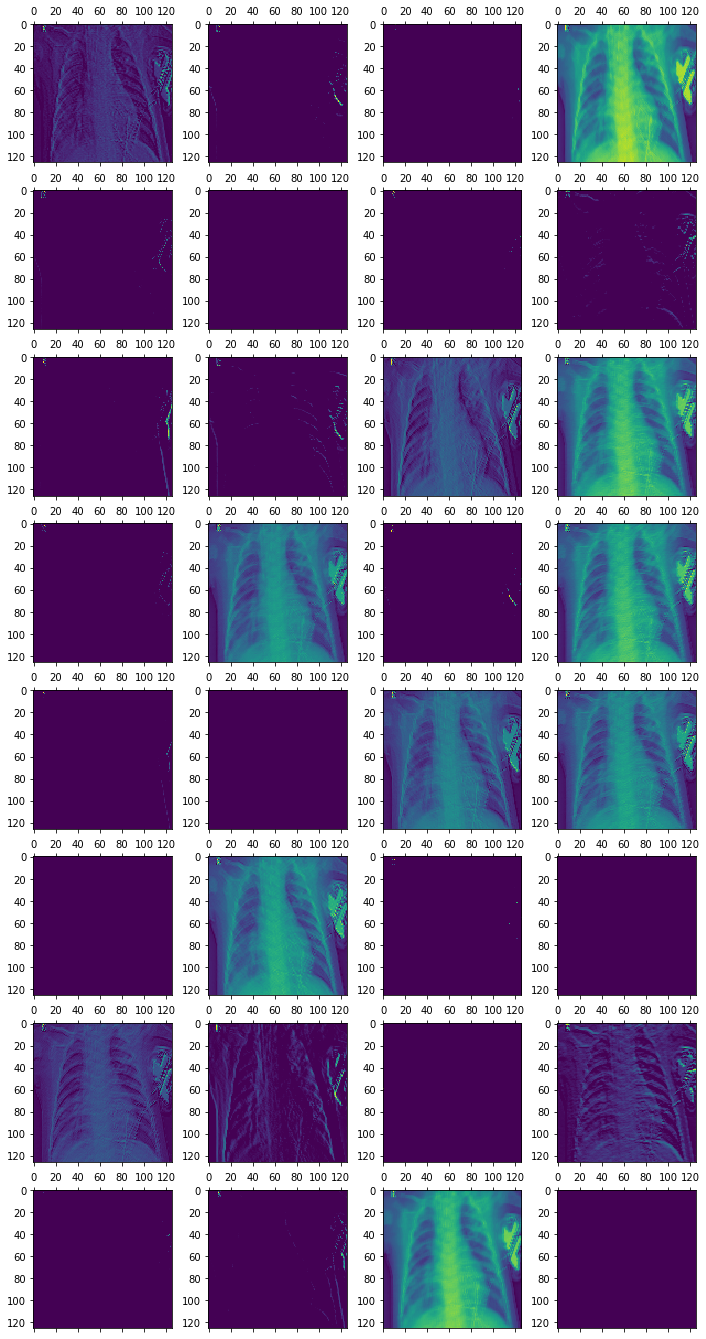

In [384]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

#### Lets visulaize the third activation layer 

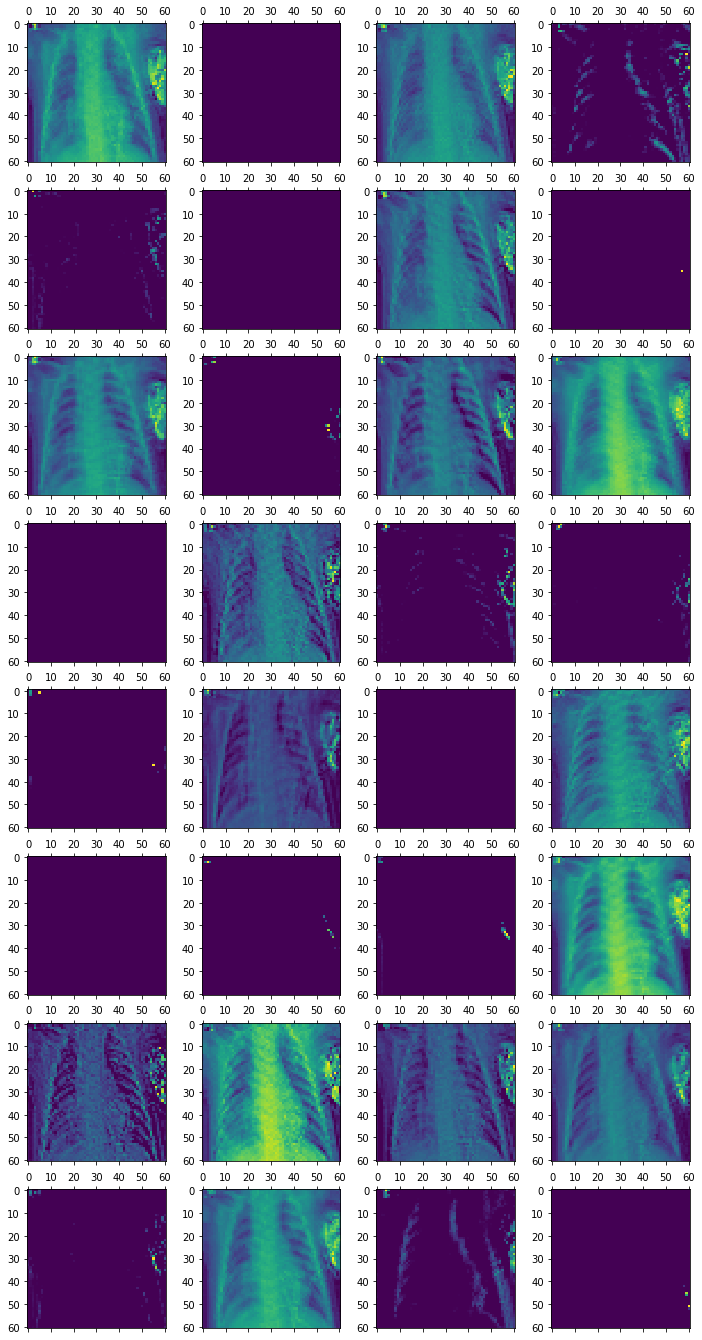

In [390]:
#second_layer_activation = activations[1]
#print(second_layer_activation.shape)
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    second_layer_activation = activations[2]
    ax.matshow(second_layer_activation[0, :, :, i], cmap='viridis')

* One can see how the later activation layers capture abstract pattern while the first layer captures mode deeper patterns


### Visualize a single channel for each of the activation layers:
* Below we are looking at 15th channel fro each activation layer

conv2d_21
max_pooling2d_13
conv2d_22
max_pooling2d_14
conv2d_23
max_pooling2d_15


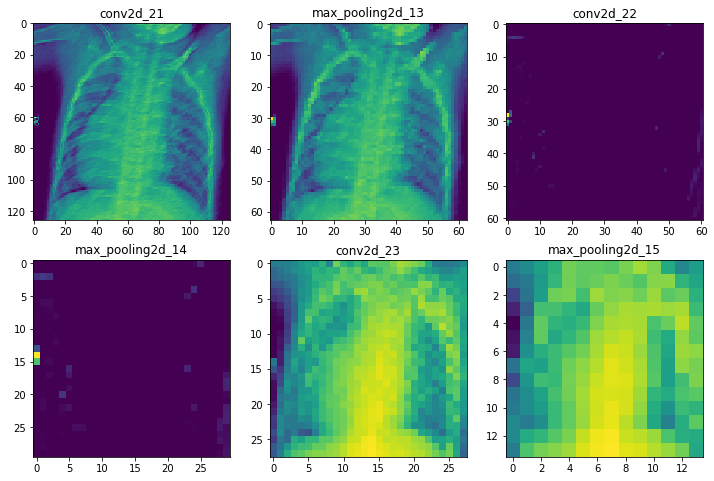

In [251]:
fig, axes = plt.subplots(2,3, figsize=(12,8))

layer_names = []
for layer in best_model.layers[:6]:
    layer_names.append(layer.name)
    print(layer.name)

for i in range(6):
    row = i//3
    column = i%3
    ax = axes[row, column]
    cur_layer = activations1[i]
    ax.matshow(cur_layer[0, :, :, 15], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])
plt.savefig('./images/activation_channel.png', dpi=300, bbox_inches='tight')    

# Model Visulaziations using LIME

* LIME, the acronym for local interpretable model-agnostic explanations, is a technique that approximates any black box machine learning model with a local, interpretable model to explain each individual prediction (https://arxiv.org/abs/1602.04938)
https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/.
* Lets visulazise one image using LIME and see how the given model has made demarcations to label the image 


In [258]:
#img_path = 'train/PNEUMONIA/BACTERIA-8705009-0002.jpeg'
#img = image.load_img(img_path, target_size=(128, 128))
#img_tensor = image.img_to_array(img)

# reshape the image into tensor to be able to use with the CNN architecture:
#img_tensor = np.expand_dims(img_tensor, axis=0)
#img_tensor /= 255.

#explanation = explainer.explain_instance(x_img, best_model.predict,  
#                                          hide_color=0, num_samples=1000)

* Functions needed for LIME
* First function returns the output from best model (CNN Augmented)
* Second function returns the output from second-best model (Xception Augmented)

In [391]:
def predict_fn(image):
    image = ((image.astype(float))/255)
    image = image.reshape((-1,128,128,3))
    return aug_cnn_deep.model(image)

In [392]:
def predict_fn2(image):
    image = ((image.astype(float))/255)
    image = image.reshape((-1,128,128,3))
    return xception_aug_deep.model(image)

In [393]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

* Lets see the original image as it is !

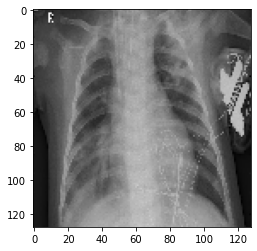

In [394]:
plt.imshow(img_tensor[0])

In [395]:
np.double( predict_fn(img_tensor[0]))

0.9930863380432129

In [396]:
np.double( predict_fn2(img_tensor[0]))

0.9442552328109741

* Lime explanation functions

In [397]:
explanation_0 = explainer.explain_instance(np.double(img_tensor[0]), predict_fn, top_labels=2, hide_color=0, num_samples=1000)

In [398]:
explanation_1 = explainer.explain_instance(np.double(img_tensor[0]), predict_fn2, top_labels=2, hide_color=0, num_samples=1000)

### Lets plot the mask boundaries for two models
*Towards and against - green and red respectively.

In [399]:
from skimage.segmentation import mark_boundaries

temp, mask = explanation_0.get_image_and_mask(explanation_0.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp, mask))

In [400]:
temp1, mask1 = explanation_1.get_image_and_mask(explanation_1.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
#plt.imshow(mark_boundaries(temp1, mask1))

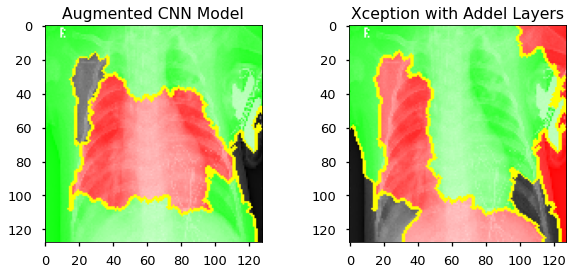

In [401]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))  
    
    ax1.imshow(mark_boundaries(temp, mask))
    ax1.set_title('Augmented CNN Model')
    
    ax2.imshow(mark_boundaries(temp1, mask1))
    ax2.set_title('Xception with Addel Layers')

* The two models work differently by defining boundaries somewhat differently! 

### Lets now look at the Heatmap - The more blue it is, the higher positive impact!

In [402]:
ind =  explanation_0.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation_0.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation_0.segments) 

ind1 =  explanation_1.top_labels[0]
dict_heatmap1 = dict(explanation_1.local_exp[ind1])
heatmap1 = np.vectorize(dict_heatmap1.get)(explanation_1.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.

#plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
#plt.colorbar()

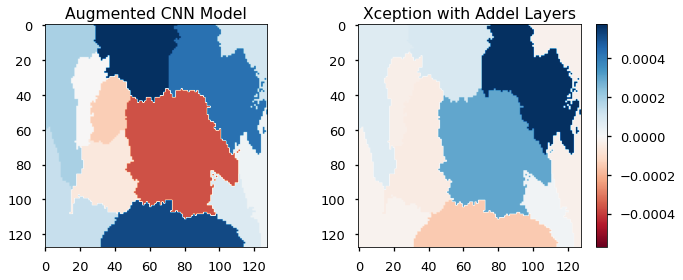

In [403]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4),sharey=False)  
    
    s1 = ax1.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    ax1.set_title('Augmented CNN Model')
    #fig.colorbar(s1, ax=ax1,orientation='vertical')
    s2 =ax2.imshow(heatmap1, cmap = 'RdBu', vmin  = -heatmap1.max(), vmax = heatmap1.max())
    ax2.set_title('Xception with Addel Layers')
    fig.colorbar(s2, ax=ax2,orientation='vertical')
    plt.tight_layout()
    plt.savefig('./images/Topmodels_lime_comp.pdf', dpi=300, bbox_inches='tight')

* One can see how the two models has slight variations in defining the importance for various sections of a given image

# Recommendations

* Neural network are a useful tool to aid the healthcare professional in stream-lining the diagnosing process when classifying x-ray images. This will allow for a quicker return time and greater patient satisfaction.

* Detecting people that have pneumonia as early as possible is very important for early intervention. Using neural networks for x-ray image clasiification will significantly reduce the waiting times for patients to hear back from radiologist and their treatment recommendations.

* The Radiologist will have reduction in his work-load and there will be a mechanism to provide continued care for patients when the radiologist is out on sick leave or has to take vacations


# Further Improvements
* We probably need to implememt weights in the training to take into account class imbalance using oversampling techniques which could improve performance. 
* Cropping images to remove unnecessary captured details such as R may bring some improvement to models.